# IMPORTAÇÃO DE PACOTES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# METADADOS

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" width="800"></img>

In [2]:
df_bureau_balance = pd.read_csv('./datasets_trabalho/bureau_balance.csv')
df_bureau = pd.read_csv('./datasets_trabalho/bureau.csv')
df_installments_payments = pd.read_csv('./datasets_trabalho/installments_payments.csv')
df_credit_card_balance = pd.read_csv('./datasets_trabalho/credit_card_balance.csv')
df_pos_cash_bal = pd.read_csv('./datasets_trabalho/POS_CASH_balance.csv')
df_previous_application = pd.read_csv('./datasets_trabalho/previous_application.csv')
df_test = pd.read_csv('./datasets_trabalho/application_test_student.csv')
df_train = pd.read_csv('./datasets_trabalho/application_train.csv')

In [3]:
def info(df):
    display(df.info())
    display(df.dtypes.value_counts())
    pd.set_option('display.max_columns', None)
    display(df.head())
    pd.reset_option('max_columns')
    print(df.columns.values)
    return

def contagem_cat(df, col, size=[8, 4]):
    df1 = pd.DataFrame(df[col].value_counts())
    df2 = pd.DataFrame((100. * df1 / df1.sum()).round(1).astype(str) + '%')
    df1[col + ' %'] = df2[col]
    plot_cat(df=df1, title = col, size = size)
    return df1

def missing(df):
    df1 = pd.DataFrame(df.isna().sum())
    if df1.sum()[0] == 0:
        print('Não há NaNs')
        return df1
    else:
        df2 = pd.DataFrame((100. * df1 / df1.sum()).round(1).astype(str) + '%')
        df1[1] = df2
        df1.columns = ['Qtd', "Qtd %"]
        return df1
    
def plot_cat(df, size = [8, 4], title = ''):
    df1 = df.iloc[:,0].copy()
    plt.figure(figsize = size)
    sns.barplot(x = df1.index, y = df1.values)
    plt.title(label = title)
    plt.show()

def plot_cat2(df, col, size = [8, 4], xlabel_angle = 0, title = ''):
    plt.figure(figsize = size)
    plot1 = df.loc[df['TARGET'] == 1, col].value_counts()
    plot2 = df.loc[df['TARGET'] == 0, col].value_counts()
    plt.subplot(1,2,1)
    sns.barplot(x = plot1.index, y=plot1.values)
    plt.title('Inadimplente: Categoria ' + title)
    plt.xticks(rotation=xlabel_angle)
    plt.subplot(1,2,2)
    sns.barplot(x = plot2.index, y=plot2.values)
    plt.title('Não inadimplente: Categoria ' + title)
    plt.xticks(rotation=xlabel_angle)
    plt.show()
    
def plot_num(df, col, size=[8, 4], bins=20, title = 'Distribuição'):
    plt.figure(figsize = size)
    plt.title(label = title)
    sns.histplot(df[col].dropna(), kde=True, bins=bins)
    plt.show()
    return

# EDA E LIMPEZA

### BASES: BUREAU E BUREAU BALANCE

Os dados contidos na planilha 'bureau_balance' demonstram o status de cada empréstimo mês a mês para todos os clientes. Vamos verificar como se comportam os dados:

In [4]:
info(df_bureau_balance)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


None

int64     2
object    1
dtype: int64

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


['SK_ID_BUREAU' 'MONTHS_BALANCE' 'STATUS']


In [5]:
missing(df_bureau_balance)

Não há NaNs


,0
SK_ID_BUREAU,0
MONTHS_BALANCE,0
STATUS,0


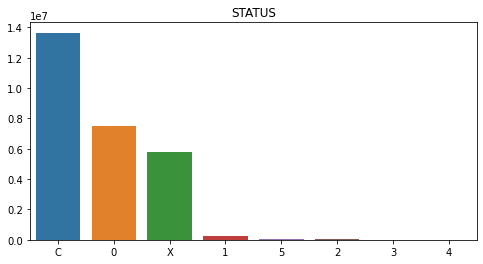

,STATUS,STATUS %
C,13646993,50.0%
0,7499507,27.5%
X,5810482,21.3%
1,242347,0.9%
5,62406,0.2%
2,23419,0.1%
3,8924,0.0%
4,5847,0.0%


In [6]:
contagem_cat(df_bureau_balance, 'STATUS')

Percebe-se que 21,3% dos dados são do tipo 'missing' (dados com status 'X'). Como eles estão distribuídos entre os dados preenchidos sem nenhum padrão claro, muitas vezes não havendo nenhum dado preenchido para certos ID's, é difícil intuir uma forma precisa de preenchimento.

Como os dados ausentes representam menos de 20% da base total, estes serão considerados apenas como 0 ou C, que representam meses com pagamento em dia. Como o intuito desta parte da análise é verificar se em algum dos meses houve inadimplencia, qualquer mês que seja, não haverá tanto impacto se a consideração for feita desta forma.

Será criado um DF auxiliar, que irá receber um valor unitário para cada mês de inadimplencia do empréstimo (coluna AUX). Esse dataframe será então agrupado pelos ID's, e todos os empréstimos que estiverem com a contagem maior do que 0 (representando que houve inadimplência em algum mês) receberão valor 1 na nova coluna 'DEFAULT', enquanto que os demais receberão valor 0. Essa nova coluna vai indicar se há histórico de inadimplência para cada empréstimo, sendo 0 = não e 1 = sim.

In [7]:
df_aux=df_bureau_balance.copy()
df_aux['AUX']=np.where(((df_aux['STATUS'] == '1') | (df_aux['STATUS'] == '2') | (df_aux['STATUS'] == '3') | (df_aux['STATUS'] == '4') | (df_aux['STATUS'] == '5')), 1, 0)
df_aux = df_aux.groupby(['SK_ID_BUREAU']).sum().drop(['MONTHS_BALANCE'],axis='columns')
df_aux['DEFAULT']=np.where(df_aux['AUX']>=1,1,0)
df_aux.head(10)

,AUX,DEFAULT
SK_ID_BUREAU,,
5001709,0,0
5001710,0,0
5001711,0,0
5001712,0,0
5001713,0,0
5001714,0,0
5001715,0,0
5001716,0,0
5001717,0,0


Vamos confrontar os dados com o dataframe original e verificar se os ID's sinalizados com default 1 realmente possuem histórico de inadimplência:

In [8]:
df_bureau_balance[df_bureau_balance['SK_ID_BUREAU']==5001717]['STATUS'].value_counts()

0    17
C     5
Name: STATUS, dtype: int64

In [9]:
df_bureau_balance[df_bureau_balance['SK_ID_BUREAU']==5001718]['STATUS'].value_counts()

0    24
X    10
C     3
1     2
Name: STATUS, dtype: int64

Percebe-se que o algoritmo funciona corretamente, com os empréstimos com algum histórico de inadimplência sendo marcados com DEFAULT = 1. Vamos então dropar a coluna auxiliar e esta parte da análise está pronta.

In [10]:
df_aux.drop('AUX', axis='columns', inplace=True)

In [11]:
df_aux['DEFAULT'].value_counts()

0    714131
1    103264
Name: DEFAULT, dtype: int64

Passemos então ao DF bureau:

In [12]:
info(df_bureau)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


None

float64    8
int64      6
object     3
dtype: int64

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.000,-153.000,NaN,0,91323.000,0.000,NaN,0.000,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.000,NaN,NaN,0,225000.000,171342.000,NaN,0.000,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.000,NaN,NaN,0,464323.500,NaN,NaN,0.000,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.000,NaN,NaN,0.000,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.000,NaN,77674.500,0,2700000.000,NaN,NaN,0.000,Consumer credit,-21,NaN


['SK_ID_CURR' 'SK_ID_BUREAU' 'CREDIT_ACTIVE' 'CREDIT_CURRENCY'
 'DAYS_CREDIT' 'CREDIT_DAY_OVERDUE' 'DAYS_CREDIT_ENDDATE'
 'DAYS_ENDDATE_FACT' 'AMT_CREDIT_MAX_OVERDUE' 'CNT_CREDIT_PROLONG'
 'AMT_CREDIT_SUM' 'AMT_CREDIT_SUM_DEBT' 'AMT_CREDIT_SUM_LIMIT'
 'AMT_CREDIT_SUM_OVERDUE' 'CREDIT_TYPE' 'DAYS_CREDIT_UPDATE' 'AMT_ANNUITY']


In [13]:
missing(df_bureau)

,Qtd,Qtd %
SK_ID_CURR,0,0.0%
SK_ID_BUREAU,0,0.0%
CREDIT_ACTIVE,0,0.0%
CREDIT_CURRENCY,0,0.0%
DAYS_CREDIT,0,0.0%
CREDIT_DAY_OVERDUE,0,0.0%
DAYS_CREDIT_ENDDATE,105553,2.7%
DAYS_ENDDATE_FACT,633653,16.1%
AMT_CREDIT_MAX_OVERDUE,1124488,28.5%
CNT_CREDIT_PROLONG,0,0.0%


O dataframe criado anteriormente pode ser agrupado com o da base 'bureau' através de um join com a coluna 'SK_ID_BUREAU', comum às duas bases. Há mais empréstimos na base de dados bureau do que na base tratada, então alguns valores ficarão missing. Façamos como Left join para passar todos os dados de 'DEFAULT' para os dados existentes na base bureau.

In [14]:
df_bureau = df_bureau.join(df_aux, on='SK_ID_BUREAU', how='inner')

In [15]:
info(df_bureau)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774354 entries, 768 to 1716292
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SK_ID_CURR              774354 non-null  int64  
 1   SK_ID_BUREAU            774354 non-null  int64  
 2   CREDIT_ACTIVE           774354 non-null  object 
 3   CREDIT_CURRENCY         774354 non-null  object 
 4   DAYS_CREDIT             774354 non-null  int64  
 5   CREDIT_DAY_OVERDUE      774354 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     723869 non-null  float64
 7   DAYS_ENDDATE_FACT       490889 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  234704 non-null  float64
 9   CNT_CREDIT_PROLONG      774354 non-null  int64  
 10  AMT_CREDIT_SUM          774349 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     662000 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    477791 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  774354 non-null  float64
 14  CREDIT_TYPE      

None

float64    8
int64      6
object     3
int32      1
dtype: int64

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DEFAULT
768,380361,5715448,Active,currency 1,-820,0,31069.000,NaN,NaN,0,67500.000,0.000,67500.000,0.000,Credit card,-183,0.000,0
769,380361,5715449,Active,currency 1,-357,0,1119.000,NaN,NaN,0,45000.000,0.000,45000.000,0.000,Credit card,-130,2691.000,0
770,380361,5715451,Closed,currency 1,-917,0,-187.000,-759.000,NaN,0,74439.000,0.000,0.000,0.000,Consumer credit,-748,0.000,0
771,380361,5715452,Closed,currency 1,-993,0,31039.000,-831.000,NaN,0,315000.000,0.000,0.000,0.000,Credit card,-818,0.000,0
772,380361,5715453,Closed,currency 1,-1146,0,681.000,-780.000,NaN,0,2025000.000,0.000,0.000,0.000,Consumer credit,-769,0.000,0


['SK_ID_CURR' 'SK_ID_BUREAU' 'CREDIT_ACTIVE' 'CREDIT_CURRENCY'
 'DAYS_CREDIT' 'CREDIT_DAY_OVERDUE' 'DAYS_CREDIT_ENDDATE'
 'DAYS_ENDDATE_FACT' 'AMT_CREDIT_MAX_OVERDUE' 'CNT_CREDIT_PROLONG'
 'AMT_CREDIT_SUM' 'AMT_CREDIT_SUM_DEBT' 'AMT_CREDIT_SUM_LIMIT'
 'AMT_CREDIT_SUM_OVERDUE' 'CREDIT_TYPE' 'DAYS_CREDIT_UPDATE' 'AMT_ANNUITY'
 'DEFAULT']


Para este resultante Bureau, os dados serão tratados para manter apenas uma ocorrência por SK_ID_CURR, facilitando joins posteriores. Para isso, serão somados os créditos para cada ID, contando a quantidade de créditos abertos e fechados, contando os totais de atraso e somando todos os valores de créditos obtidos. Iniciamos removendo as features que não serão mantidas:

In [16]:
df_bureau.drop(['CREDIT_CURRENCY','DAYS_CREDIT','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG', 
    'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE','AMT_ANNUITY'], axis = 'columns', inplace=True)
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_OVERDUE,DEFAULT
768,380361,5715448,Active,0,67500.000,0.000,0
769,380361,5715449,Active,0,45000.000,0.000,0
770,380361,5715451,Closed,0,74439.000,0.000,0
771,380361,5715452,Closed,0,315000.000,0.000,0
772,380361,5715453,Closed,0,2025000.000,0.000,0


Serão criadas então dummies para as variáveis da feature 'CREDIT_ACTIVE', para separarmos a mesma entre crédito ativo e fechado. Depois será aplicado o groupby pelos ID'S somando as features restantes, de forma que a feature DEFAULT resultante será dividida pelo número total de créditos abertos e fechados do cliente. Isso resultará na feature DEFAULT_RATE_BUREAU, que apresentará uma taxa de inadimplencia do cliente com o pagamento de seus créditos.

In [17]:
df_bureau['CREDIT_ACTIVE']=df_bureau['CREDIT_ACTIVE'].replace(['Sold','Bad debt'],'Closed')
df_bureau = pd.get_dummies(df_bureau, columns = ['CREDIT_ACTIVE'])
df_bureau = df_bureau.rename(columns={'CREDIT_ACTIVE_Active':'N_ACTIVE_CREDITS_BUREAU','CREDIT_ACTIVE_Closed':'N_CLOSED_CREDITS_BUREAU','AMT_CREDIT_SUM_OVERDUE':'BUREAU_CURRENT_SUM_OVERDUE'})
df_bureau = df_bureau.groupby(['SK_ID_CURR'], as_index = False, sort = False).sum()
df_bureau['DEFAULT_RATE'] = df_bureau['DEFAULT']/(df_bureau['N_ACTIVE_CREDITS_BUREAU']+df_bureau['N_CLOSED_CREDITS_BUREAU'])
df_bureau.drop('DEFAULT',axis='columns',inplace=True)
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,BUREAU_CURRENT_SUM_OVERDUE,N_ACTIVE_CREDITS_BUREAU,N_CLOSED_CREDITS_BUREAU,DEFAULT_RATE
0,380361,96627785,0,12093160.500,0.000,7,10,0.000
1,125263,10895977,0,323631.000,0.000,2,0,1.000
2,275240,22326937,0,516348.000,0.000,2,2,0.500
3,399518,11430947,0,397165.500,0.000,1,1,0.000
4,215382,22326976,0,134972.550,0.000,0,4,0.000


In [18]:
df_bureau.shape

(134542, 8)

Vamos analisar agora as bases de dados 'Credit_Card_Balance' e 'Installments_Payments', que se conectam através da feature 'SK_ID_PREV'

### INSTALLMENTS PAYMENTS

Analisemos a base de parcelamentos. Aqui são descritas cada parcela paga (ou não) para cada empréstimo passado de cada cliente:

In [19]:
info(df_installments_payments)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


None

float64    5
int64      3
dtype: int64

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.000,6,-1180.000,-1187.000,6948.360,6948.360
1,1330831,151639,0.000,34,-2156.000,-2156.000,1716.525,1716.525
2,2085231,193053,2.000,1,-63.000,-63.000,25425.000,25425.000
3,2452527,199697,1.000,3,-2418.000,-2426.000,24350.130,24350.130
4,2714724,167756,1.000,2,-1383.000,-1366.000,2165.040,2160.585


['SK_ID_PREV' 'SK_ID_CURR' 'NUM_INSTALMENT_VERSION'
 'NUM_INSTALMENT_NUMBER' 'DAYS_INSTALMENT' 'DAYS_ENTRY_PAYMENT'
 'AMT_INSTALMENT' 'AMT_PAYMENT']


In [20]:
missing(df_installments_payments)

,Qtd,Qtd %
SK_ID_PREV,0,0.0%
SK_ID_CURR,0,0.0%
NUM_INSTALMENT_VERSION,0,0.0%
NUM_INSTALMENT_NUMBER,0,0.0%
DAYS_INSTALMENT,0,0.0%
DAYS_ENTRY_PAYMENT,2905,50.0%
AMT_INSTALMENT,0,0.0%
AMT_PAYMENT,2905,50.0%


Percebe-se que há uma pequena quantidade de nulos. Vejamos como se comportam:

In [21]:
df_installments_payments[df_installments_payments['DAYS_ENTRY_PAYMENT'].isna()].head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3764207,1531600,103793,1.000,7,-668.000,NaN,49741.020,NaN
3764208,1947105,159974,1.000,24,-36.000,NaN,22849.515,NaN
3764209,1843773,167270,1.000,22,-20.000,NaN,48092.355,NaN
3764210,1691592,192536,1.000,5,-2561.000,NaN,7675.425,NaN
3764211,1531299,157088,0.000,11,-1847.000,NaN,67.500,NaN
3764212,1562727,187345,0.000,23,-5.000,NaN,11401.740,NaN
3764213,1265332,167942,1.000,5,-14.000,NaN,11650.500,NaN
3764214,1531600,103793,1.000,25,-128.000,NaN,49741.020,NaN
3764215,1852469,103171,7.000,3,-49.000,NaN,311738.355,NaN
3764216,1054684,142217,0.000,38,-1469.000,NaN,67.500,NaN


Por representarem uma pequena parcela do dataset, estes dados poderiam ser dropados em outras ocasiões. Aqui, entretanto, os dados missing representam parcelas não pagas. Uma vez que buscamos históricos de inadimplência, estes dados são úteis para a construção de nosso modelo. Desta forma, em ambas as features ('DAYS_ENTRY_PAYMENT' - Dias desde o pagamento da parcela / 'AMT_PAYMENT' - Total pago) serão preenchidas com zeros, para utilização em fase posterior

In [22]:
df_installments_payments.fillna(0, inplace=True)
df_installments_payments.isna().sum()

SK_ID_PREV                0
SK_ID_CURR                0
NUM_INSTALMENT_VERSION    0
NUM_INSTALMENT_NUMBER     0
DAYS_INSTALMENT           0
DAYS_ENTRY_PAYMENT        0
AMT_INSTALMENT            0
AMT_PAYMENT               0
dtype: int64

In [23]:
df_installments_payments[df_installments_payments['NUM_INSTALMENT_VERSION']==0.0].count()

SK_ID_PREV                4082498
SK_ID_CURR                4082498
NUM_INSTALMENT_VERSION    4082498
NUM_INSTALMENT_NUMBER     4082498
DAYS_INSTALMENT           4082498
DAYS_ENTRY_PAYMENT        4082498
AMT_INSTALMENT            4082498
AMT_PAYMENT               4082498
dtype: int64

In [24]:
df_aux2 = df_installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR','NUM_INSTALMENT_VERSION'], as_index = False, sort = False).sum()
df_aux2[df_aux2['NUM_INSTALMENT_VERSION']==0.0].count()

SK_ID_PREV                72678
SK_ID_CURR                72678
NUM_INSTALMENT_VERSION    72678
NUM_INSTALMENT_NUMBER     72678
DAYS_INSTALMENT           72678
DAYS_ENTRY_PAYMENT        72678
AMT_INSTALMENT            72678
AMT_PAYMENT               72678
dtype: int64

In [25]:
info(df_aux2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560516 entries, 0 to 1560515
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_PREV              1560516 non-null  int64  
 1   SK_ID_CURR              1560516 non-null  int64  
 2   NUM_INSTALMENT_VERSION  1560516 non-null  float64
 3   NUM_INSTALMENT_NUMBER   1560516 non-null  int64  
 4   DAYS_INSTALMENT         1560516 non-null  float64
 5   DAYS_ENTRY_PAYMENT      1560516 non-null  float64
 6   AMT_INSTALMENT          1560516 non-null  float64
 7   AMT_PAYMENT             1560516 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 95.2 MB


None

float64    5
int64      3
dtype: int64

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.000,78,-13980.000,-14296.000,83367.180,83367.180
1,1330831,151639,0.000,5465,-159100.000,-159346.000,242893.395,239518.395
2,2085231,193053,2.000,1,-63.000,-63.000,25425.000,25425.000
3,2452527,199697,1.000,21,-14418.000,-14466.000,145997.865,145997.865
4,2714724,167756,1.000,11,-6885.000,-6910.000,10825.200,6495.120


['SK_ID_PREV' 'SK_ID_CURR' 'NUM_INSTALMENT_VERSION'
 'NUM_INSTALMENT_NUMBER' 'DAYS_INSTALMENT' 'DAYS_ENTRY_PAYMENT'
 'AMT_INSTALMENT' 'AMT_PAYMENT']


In [26]:
missing(df_aux2)

Não há NaNs


,0
SK_ID_PREV,0
SK_ID_CURR,0
NUM_INSTALMENT_VERSION,0
NUM_INSTALMENT_NUMBER,0
DAYS_INSTALMENT,0
DAYS_ENTRY_PAYMENT,0
AMT_INSTALMENT,0
AMT_PAYMENT,0


Será então criada uma nova feature para este DF resultante, 'DAYS_LATE', que representa o total de dias de atraso no pagamento para a parcela em questão (dias negativos representam pagamentos antes do prazo). Será criada também uma feature para representar a quantidade não paga para a parcela em questão, 'AMT_UNPAID'.

In [27]:
df_installments_payments['DAYS_BALANCE'] = df_installments_payments['DAYS_ENTRY_PAYMENT'] - df_installments_payments['DAYS_INSTALMENT']
df_installments_payments = df_installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR','NUM_INSTALMENT_NUMBER'], 
    as_index = False, 
    sort = False).agg({'NUM_INSTALMENT_VERSION':'first','DAYS_INSTALMENT':'first','DAYS_ENTRY_PAYMENT':'first','DAYS_BALANCE':'sum','AMT_INSTALMENT':'first','AMT_PAYMENT':'sum'})
df_installments_payments['AMT_UNPAID'] = df_installments_payments['AMT_INSTALMENT'] - df_installments_payments['AMT_PAYMENT']
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_NUMBER,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,DAYS_BALANCE,AMT_INSTALMENT,AMT_PAYMENT,AMT_UNPAID
0,1054186,161674,6,1.000,-1180.000,-1187.000,-7.000,6948.360,6948.360,0.000
1,1330831,151639,34,0.000,-2156.000,-2156.000,0.000,1716.525,1716.525,0.000
2,2085231,193053,1,2.000,-63.000,-63.000,23.000,25425.000,26056.035,-631.035
3,2452527,199697,3,1.000,-2418.000,-2426.000,-8.000,24350.130,24350.130,0.000
4,2714724,167756,2,1.000,-1383.000,-1366.000,-21.000,2165.040,2165.040,0.000


Neste ponto, as features 'NUM_INSTALMENT_VERSION' e 'NUM_INSTALMENT_NUMBER' (que correspondem à versão do calendário de pagamento das parcelas e ao número da parcela observada, respectivamente) passam a ter pouco valor analítico, então serão dropadas. As features 'DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT' e 'AMT_PAYMENT' também serão dropadas, por fazerem parte das features resultantes criadas anteriormente.

In [28]:
df_installments_payments.drop(['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','DAYS_ENTRY_PAYMENT','AMT_PAYMENT','DAYS_INSTALMENT'], axis = 'columns', inplace=True)
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID
0,1054186,161674,-7.000,6948.360,0.000
1,1330831,151639,0.000,1716.525,0.000
2,2085231,193053,23.000,25425.000,-631.035
3,2452527,199697,-8.000,24350.130,0.000
4,2714724,167756,-21.000,2165.040,0.000


Por fim, os dados são agrupados pelos ID's de cada transação e cada cliente, formando um novo DF que conta com o balanço de dias em atraso (valores negativos significa um saldo de dias adiantados), total de todas as parcelas e total não pago:

In [29]:
df_installments_payments = df_installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False, sort = False).sum()
df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID
0,1054186,161674,-316.000,83367.180,0.000
1,1330831,151639,-246.000,239518.395,0.000
2,2085231,193053,16.000,33818.175,-631.035
3,2452527,199697,-48.000,145997.865,0.000
4,2714724,167756,-38.000,16186.410,0.000


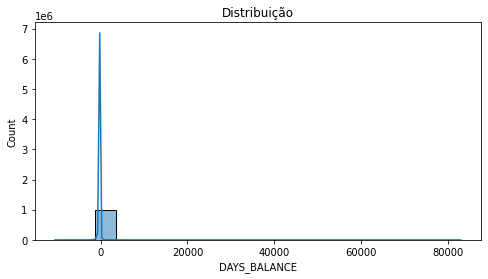

In [30]:
plot_num(df_installments_payments, 'DAYS_BALANCE', size=[8, 4], bins=20)

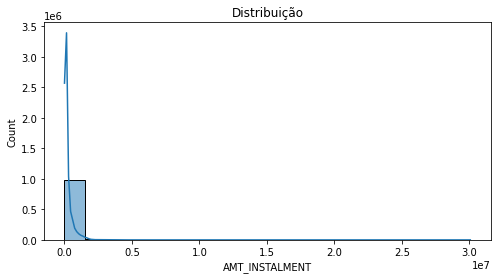

In [31]:
plot_num(df_installments_payments, 'AMT_INSTALMENT', size=[8, 4], bins=20)

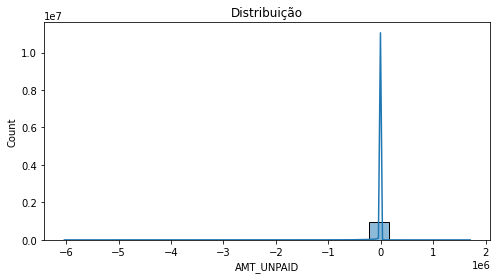

In [32]:
plot_num(df_installments_payments, 'AMT_UNPAID', size=[8, 4], bins=20)

### CREDIT CARD BALANCE

Neste ponto será analisada a base 'Credit Card Balance', que agrega dados do cartão de crédito de alguns clientes mês a mês

In [33]:
info(df_credit_card_balance)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

None

float64    15
int64       7
object      1
dtype: int64

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.000,877.500,0.000,877.500,1700.325,1800.000,1800.000,0.000,0.000,0.000,0.000,1,0.000,1.000,35.000,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.000,2250.000,0.000,0.000,2250.000,2250.000,2250.000,60175.080,64875.555,64875.555,1.000,1,0.000,0.000,69.000,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.000,0.000,0.000,0.000,2250.000,2250.000,2250.000,26926.425,31460.085,31460.085,0.000,0,0.000,0.000,30.000,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.000,2250.000,0.000,0.000,11795.760,11925.000,11925.000,224949.285,233048.970,233048.970,1.000,1,0.000,0.000,10.000,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.000,11547.000,0.000,11547.000,22924.890,27000.000,27000.000,443044.395,453919.455,453919.455,0.000,1,0.000,1.000,101.000,Active,0,0


['SK_ID_PREV' 'SK_ID_CURR' 'MONTHS_BALANCE' 'AMT_BALANCE'
 'AMT_CREDIT_LIMIT_ACTUAL' 'AMT_DRAWINGS_ATM_CURRENT'
 'AMT_DRAWINGS_CURRENT' 'AMT_DRAWINGS_OTHER_CURRENT'
 'AMT_DRAWINGS_POS_CURRENT' 'AMT_INST_MIN_REGULARITY'
 'AMT_PAYMENT_CURRENT' 'AMT_PAYMENT_TOTAL_CURRENT'
 'AMT_RECEIVABLE_PRINCIPAL' 'AMT_RECIVABLE' 'AMT_TOTAL_RECEIVABLE'
 'CNT_DRAWINGS_ATM_CURRENT' 'CNT_DRAWINGS_CURRENT'
 'CNT_DRAWINGS_OTHER_CURRENT' 'CNT_DRAWINGS_POS_CURRENT'
 'CNT_INSTALMENT_MATURE_CUM' 'NAME_CONTRACT_STATUS' 'SK_DPD' 'SK_DPD_DEF']


In [34]:
missing(df_credit_card_balance)

,Qtd,Qtd %
SK_ID_PREV,0,0.0%
SK_ID_CURR,0,0.0%
MONTHS_BALANCE,0,0.0%
AMT_BALANCE,0,0.0%
AMT_CREDIT_LIMIT_ACTUAL,0,0.0%
AMT_DRAWINGS_ATM_CURRENT,749816,12.8%
AMT_DRAWINGS_CURRENT,0,0.0%
AMT_DRAWINGS_OTHER_CURRENT,749816,12.8%
AMT_DRAWINGS_POS_CURRENT,749816,12.8%
AMT_INST_MIN_REGULARITY,305236,5.2%


Vamos verificar quantos registros de créditos há nesse dataset. Para isso, agruparemos os dados pelos ID's, onde será desconsiderado o efeito mês a mês:

In [35]:
df_credit_card_balance.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False, sort = False).sum()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
0,2562384,378907,-1175,1314751.680,9036000,67500.000,124941.645,0.000,57441.645,92335.590,...,1271878.605,1322191.980,1322191.980,1.000,8,0.000,7.000,983.000,6,6
1,2582071,363914,-4656,3158006.580,6120000,293850.000,358313.670,0.000,64463.670,206433.000,...,3003606.405,3160853.370,3160853.370,31.000,42,0.000,11.000,4209.000,1,1
2,1740877,371185,-703,4165194.015,13999500,506250.000,699566.715,0.000,193316.715,214735.860,...,4011337.530,4153952.160,4153952.160,21.000,104,0.000,83.000,666.000,0,0
3,1389973,337855,-120,2837609.145,3015000,50850.000,259850.835,0.000,209000.835,127967.715,...,2713099.725,2794483.845,2794483.845,15.000,75,0.000,60.000,91.000,0,0
4,1891521,126868,-4656,18676199.565,21870000,763650.000,1372493.385,0.000,608843.385,970803.810,...,18101481.345,18674419.590,18674419.590,40.000,144,0.000,104.000,5136.000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104302,2339982,318916,-1,0.000,45000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0,0
104303,2720102,174455,-1,0.000,225000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0,0
104304,1897864,315041,-2,0.000,270000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0,0
104305,2481982,382749,-1,0.000,270000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0,0


As features 'SD_DPD_DEF','CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_POS_CURRENTS','CNT_DRAWINGS_OTHER_CURRENT' serão dropadas em um primeiro momento por não serem significativas para a análise pretendida

In [36]:
df_credit_card_balance.drop(['CNT_DRAWINGS_POS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT','CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_ATM_CURRENT','SK_DPD_DEF'],axis='columns',inplace=True)
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD
0,2562384,378907,-6,56.970,135000,0.000,877.500,0.000,877.500,1700.325,1800.000,1800.000,0.000,0.000,0.000,35.000,Active,0
1,2582071,363914,-1,63975.555,45000,2250.000,2250.000,0.000,0.000,2250.000,2250.000,2250.000,60175.080,64875.555,64875.555,69.000,Active,0
2,1740877,371185,-7,31815.225,450000,0.000,0.000,0.000,0.000,2250.000,2250.000,2250.000,26926.425,31460.085,31460.085,30.000,Active,0
3,1389973,337855,-4,236572.110,225000,2250.000,2250.000,0.000,0.000,11795.760,11925.000,11925.000,224949.285,233048.970,233048.970,10.000,Active,0
4,1891521,126868,-1,453919.455,450000,0.000,11547.000,0.000,11547.000,22924.890,27000.000,27000.000,443044.395,453919.455,453919.455,101.000,Active,0


Agora analisemos os dados nulos:

In [37]:
df_credit_card_balance[df_credit_card_balance.isna()==True]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Percebe-se que os casos em que os valores estão missing são para situações sem movimentação no cartão de crédito. Percebe-se também que algumas dessas situações sem movimentações permanece sem movimentação por todo o período registrado, o que pode indicar contas em desuso. Desta forma, os valores missing do DF serão substituídos por 0.

In [38]:
df_credit_card_balance.fillna(0, inplace=True)
df_credit_card_balance.isna().sum()

SK_ID_PREV                    0
SK_ID_CURR                    0
MONTHS_BALANCE                0
AMT_BALANCE                   0
AMT_CREDIT_LIMIT_ACTUAL       0
AMT_DRAWINGS_ATM_CURRENT      0
AMT_DRAWINGS_CURRENT          0
AMT_DRAWINGS_OTHER_CURRENT    0
AMT_DRAWINGS_POS_CURRENT      0
AMT_INST_MIN_REGULARITY       0
AMT_PAYMENT_CURRENT           0
AMT_PAYMENT_TOTAL_CURRENT     0
AMT_RECEIVABLE_PRINCIPAL      0
AMT_RECIVABLE                 0
AMT_TOTAL_RECEIVABLE          0
CNT_INSTALMENT_MATURE_CUM     0
NAME_CONTRACT_STATUS          0
SK_DPD                        0
dtype: int64

Neste ponto, as features 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_PAYMENT_CURRENT', 'AMT_RECEIVABLE', 'AMT_TOTAL_RECEIVABLE' e 'NAME_CONTRACT_STATUS' serão removidas, por serem redundantes:

In [39]:
df_credit_card_balance.drop(['MONTHS_BALANCE', 'AMT_BALANCE','AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_PAYMENT_CURRENT', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'NAME_CONTRACT_STATUS'], axis='columns', inplace=True)
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,CNT_INSTALMENT_MATURE_CUM,SK_DPD
0,2562384,378907,135000,877.500,1700.325,1800.000,0.000,35.000,0
1,2582071,363914,45000,2250.000,2250.000,2250.000,60175.080,69.000,0
2,1740877,371185,450000,0.000,2250.000,2250.000,26926.425,30.000,0
3,1389973,337855,225000,2250.000,11795.760,11925.000,224949.285,10.000,0
4,1891521,126868,450000,11547.000,22924.890,27000.000,443044.395,101.000,0


Será criada uma nova coluna com o saldo entre pagamento minimo e pagamento real para o mês. Será criada também uma feature auxiliar que contém valores binários para meses que ficaram em débito ou não (0 pagou a parcela em sua totalidade ou mais, 1 pagou menos do que o valor mínimo estipulado)

In [40]:
df_credit_card_balance['PAYMENT_BALANCE'] = df_credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] - df_credit_card_balance['AMT_INST_MIN_REGULARITY']
df_credit_card_balance['DEBT'] = df_credit_card_balance['PAYMENT_BALANCE'].apply(lambda x: 1 if x<0 else 0 )
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,CNT_INSTALMENT_MATURE_CUM,SK_DPD,PAYMENT_BALANCE,DEBT
0,2562384,378907,135000,877.500,1700.325,1800.000,0.000,35.000,0,99.675,0
1,2582071,363914,45000,2250.000,2250.000,2250.000,60175.080,69.000,0,0.000,0
2,1740877,371185,450000,0.000,2250.000,2250.000,26926.425,30.000,0,0.000,0
3,1389973,337855,225000,2250.000,11795.760,11925.000,224949.285,10.000,0,129.240,0
4,1891521,126868,450000,11547.000,22924.890,27000.000,443044.395,101.000,0,4075.110,0


Serão então removidas as feature relacionadas a pagamentos ('AMT_INST_MIN_REGULARITY' e 'AMT_PAYMENT_TOTAL_CURRENT), uma vez que a resultante ja consta na feature criada anteriormente. O limite de crédito também será removido, uma vez que não pode ser usado em futuras análises ao longo do tempo:

In [41]:
df_credit_card_balance.drop(['AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_TOTAL_CURRENT','AMT_CREDIT_LIMIT_ACTUAL'], axis='columns', inplace=True)
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_DRAWINGS_CURRENT,AMT_RECEIVABLE_PRINCIPAL,CNT_INSTALMENT_MATURE_CUM,SK_DPD,PAYMENT_BALANCE,DEBT
0,2562384,378907,877.500,0.000,35.000,0,99.675,0
1,2582071,363914,2250.000,60175.080,69.000,0,0.000,0
2,1740877,371185,0.000,26926.425,30.000,0,0.000,0
3,1389973,337855,2250.000,224949.285,10.000,0,129.240,0
4,1891521,126868,11547.000,443044.395,101.000,0,4075.110,0


In [42]:
df_credit_card_balance = df_credit_card_balance.sort_values(['SK_ID_PREV','SK_ID_CURR','CNT_INSTALMENT_MATURE_CUM'])
df_credit_card_balance.head(10)

,SK_ID_PREV,SK_ID_CURR,AMT_DRAWINGS_CURRENT,AMT_RECEIVABLE_PRINCIPAL,CNT_INSTALMENT_MATURE_CUM,SK_DPD,PAYMENT_BALANCE,DEBT
1375415,1000018,394447,51042.645,37542.645,0.000,0,9000.000,0
277653,1000018,394447,2335.500,39576.780,1.000,0,1650.870,0
2559582,1000018,394447,2032.560,43376.760,2.000,0,1396.710,0
2192275,1000018,394447,69156.945,108091.800,3.000,0,926.865,0
2159094,1000018,394447,22827.330,132903.000,4.000,0,1763.865,0
952884,1000030,361282,31105.755,15130.755,0.000,0,16067.250,0
1884819,1000030,361282,0.000,0.000,0.000,0,0.000,0
2192311,1000030,361282,20212.650,33725.745,0.000,0,317.655,0
2204494,1000030,361282,6368.850,36499.770,1.000,0,522.765,0
1720546,1000030,361282,25312.050,58778.280,2.000,0,-2128.185,1


Os valores serão então agrupados da seguinte forma: as features 'AMT_DRAWINGS_CURRENT', 'SK_DPD', 'PAYMENT_BALANCE' e 'DEBT' serão somadas. As demais serão mantidas com os valores mais recentes.

In [43]:
df_credit_card_balance = df_credit_card_balance.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False, sort = False).agg(
    {'AMT_DRAWINGS_CURRENT':'first','AMT_RECEIVABLE_PRINCIPAL':'first', 'PAYMENT_BALANCE':'sum',
    'CNT_INSTALMENT_MATURE_CUM':'count','SK_DPD':'sum','DEBT':'sum'})
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_DRAWINGS_CURRENT,AMT_RECEIVABLE_PRINCIPAL,PAYMENT_BALANCE,CNT_INSTALMENT_MATURE_CUM,SK_DPD,DEBT
0,1000018,394447,51042.645,37542.645,14738.310,5,0,0
1,1000030,361282,31105.755,15130.755,4637.790,8,0,4
2,1000031,131335,0.000,0.000,311714.280,16,0,0
3,1000035,436351,0.000,0.000,0.000,5,0,0
4,1000077,181153,0.000,0.000,0.000,11,0,0


Por fim, serão criadas duas features resultantes: uma que representa o balanço atual entre valor disponível para retirada e valor retirado ('DRAW_BALANCE' - valores positivos indicam que o cliente ainda possui valores a receber no momento do pedido de novo crédito. Valores negativos indicam que o cliente está em débito no momento do pedido) e outra que representa a fração de parcelas que foram pagas com valor inferior ao mínimo estipulado ('DEBT_RATIO' - Quanto mais próximo de 1, pior é o histórico de pagamento). As features usadas para a construção destas serão então dropadas:

In [44]:
df_credit_card_balance['DRAW_BALANCE'] = df_credit_card_balance['AMT_RECEIVABLE_PRINCIPAL'] - df_credit_card_balance['AMT_DRAWINGS_CURRENT']
df_credit_card_balance['DEBT_RATIO'] = df_credit_card_balance['DEBT']/df_credit_card_balance['CNT_INSTALMENT_MATURE_CUM']
df_credit_card_balance.drop(['AMT_DRAWINGS_CURRENT','AMT_RECEIVABLE_PRINCIPAL','CNT_INSTALMENT_MATURE_CUM','DEBT'],axis='columns',inplace=True)
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,PAYMENT_BALANCE,SK_DPD,DRAW_BALANCE,DEBT_RATIO
0,1000018,394447,14738.310,0,-13500.000,0.000
1,1000030,361282,4637.790,0,-15975.000,0.500
2,1000031,131335,311714.280,0,0.000,0.000
3,1000035,436351,0.000,0,0.000,0.000
4,1000077,181153,0.000,0,0.000,0.000


Finalizados os tratamentos em ambos os datasets, podemos posteriormente estudar o dataset resultante do join destes com o dataset previous application.

Passemos então à base POS_CASH_BALANCE

### POS_CASH_balance

In [45]:
info(df_pos_cash_bal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


None

int64      5
float64    2
object     1
dtype: int64

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.000,45.000,Active,0,0
1,1715348,367990,-33,36.000,35.000,Active,0,0
2,1784872,397406,-32,12.000,9.000,Active,0,0
3,1903291,269225,-35,48.000,42.000,Active,0,0
4,2341044,334279,-35,36.000,35.000,Active,0,0


['SK_ID_PREV' 'SK_ID_CURR' 'MONTHS_BALANCE' 'CNT_INSTALMENT'
 'CNT_INSTALMENT_FUTURE' 'NAME_CONTRACT_STATUS' 'SK_DPD' 'SK_DPD_DEF']


Podemos observar que a base tem 10 milhões de linhas e 8 colunas. 

In [46]:
missing(df_pos_cash_bal)

,Qtd,Qtd %
SK_ID_PREV,0,0.0%
SK_ID_CURR,0,0.0%
MONTHS_BALANCE,0,0.0%
CNT_INSTALMENT,26071,50.0%
CNT_INSTALMENT_FUTURE,26087,50.0%
NAME_CONTRACT_STATUS,0,0.0%
SK_DPD,0,0.0%
SK_DPD_DEF,0,0.0%


Para entender melhor a base, plotamos o gráfico abaixo e filtramos alguns valores para entender padrões, e, assim, criar indicadores relevantes que podem melhorar a predição, ao juntar estas informações com a base curr e prev apps

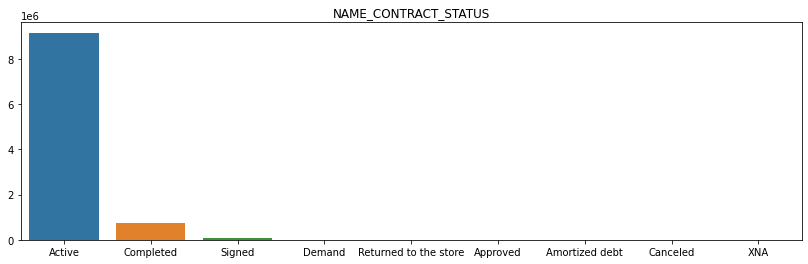

,NAME_CONTRACT_STATUS,NAME_CONTRACT_STATUS %
Active,9151119,91.5%
Completed,744883,7.4%
Signed,87260,0.9%
Demand,7065,0.1%
Returned to the store,5461,0.1%
Approved,4917,0.0%
Amortized debt,636,0.0%
Canceled,15,0.0%
XNA,2,0.0%


In [47]:
contagem_cat(df_pos_cash_bal,'NAME_CONTRACT_STATUS', size = [14, 4])

In [48]:
df_pos_cash_bal[df_pos_cash_bal['SK_ID_PREV'] == 2018040].sort_values('MONTHS_BALANCE').head(15)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2244023,2018040,381755,-91,4.000,4.000,Active,0,0
5070254,2018040,381755,-90,4.000,3.000,Active,24,24
8410497,2018040,381755,-89,4.000,2.000,Active,55,55
3258952,2018040,381755,-88,4.000,1.000,Active,86,86
2821824,2018040,381755,-87,4.000,0.000,Active,115,115
7126072,2018040,381755,-86,4.000,0.000,Active,146,146
8415766,2018040,381755,-85,4.000,0.000,Active,176,176
1381201,2018040,381755,-84,4.000,0.000,Active,207,207
598677,2018040,381755,-83,4.000,0.000,Active,237,237
251608,2018040,381755,-82,4.000,0.000,Active,268,268


In [49]:
df_pos_cash_bal[(df_pos_cash_bal['CNT_INSTALMENT_FUTURE'].isna()) & df_pos_cash_bal['CNT_INSTALMENT'].notna()].head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
297879,2076676,376299,-56,12.000,NaN,Signed,0,0
843844,1056665,451283,-58,12.000,NaN,Signed,0,0
972178,2044474,257151,-57,4.000,NaN,Signed,0,0
1113694,1685109,397218,-54,10.000,NaN,Signed,0,0
1258700,2116393,432184,-53,12.000,NaN,Signed,0,0
1456583,2116393,432184,-54,12.000,NaN,Signed,0,0
1632739,1489493,406944,-49,10.000,NaN,Signed,0,0
2001194,1355664,261279,-55,4.000,NaN,Signed,0,0
2147811,1056665,451283,-62,12.000,NaN,Signed,0,0
2649942,2333220,188098,-53,6.000,NaN,Signed,0,0


Uma vez que os dados com status diferente de 'Approved' levam a resultados inconclusivos com o numero de parcelas, todos os casos diferentes destes serão dropados nesta análise sem perda significativa dos dados.

In [50]:
df_pos_cash_bal.drop(df_pos_cash_bal.loc[df_pos_cash_bal['NAME_CONTRACT_STATUS']!='Active'].index, inplace=True)

Indicadores que podem ser interessantes:
<br>
* Serão aplicados GROUPBY'S na base, a fim de se manter apenas um registro para cada ID_PREV;
<br>
* Serão verificados os saltos na quantidade de parcelas a pagar, e estes casos serão pagos em feature auxiliar como pagamento adiantado;
<br>
* O caso oposto também será sinalizado como pagamento atrasado.

In [51]:
df_pos_cash_bal = df_pos_cash_bal.sort_values(['SK_ID_PREV','SK_ID_CURR','CNT_INSTALMENT_FUTURE'],ascending=False)
df_pos_cash_bal.head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1725739,2843499,314148,-40,60.000,60.000,Active,0,0
2178177,2843499,314148,-39,60.000,59.000,Active,0,0
9337008,2843499,314148,-38,60.000,58.000,Active,0,0
5673963,2843499,314148,-37,60.000,57.000,Active,0,0
9784083,2843499,314148,-36,60.000,56.000,Active,0,0
771297,2843499,314148,-35,60.000,55.000,Active,0,0
5675189,2843499,314148,-34,60.000,54.000,Active,0,0
1722726,2843499,314148,-33,60.000,52.000,Active,0,0
804539,2843499,314148,-32,60.000,51.000,Active,0,0
5580339,2843499,314148,-31,10.000,0.000,Active,0,0


In [52]:
df_pos_cash_bal.drop(['MONTHS_BALANCE','NAME_CONTRACT_STATUS','SK_DPD_DEF'],axis='columns',inplace=True)
df_pos_cash_bal = df_pos_cash_bal.groupby(['SK_ID_CURR','SK_ID_PREV'], as_index = False, sort = False).agg(
    {'CNT_INSTALMENT':'count','CNT_INSTALMENT_FUTURE':'first','SK_DPD':'sum'})
df_pos_cash_bal.head()

,SK_ID_CURR,SK_ID_PREV,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD
0,314148,2843499,10,60.000,0
1,393881,2843498,6,36.000,0
2,451578,2843497,21,24.000,0
3,260963,2843495,7,60.000,0
4,292375,2843494,2,48.000,0


Após o agrupamento das bases, serão criadas as features 'EARLY_PAYMENT' e 'LATE_PAYMENT', levando em consideração a quantidade de meses pagando as parcelas e a quantidade de parcelas acumuladas. Caso a quantidade de meses pagando seja menor do que o numero de parcelas, indica uma antecipação de algumas parcelas. O contrário indica um atraso. Ambas as features recebem valor de 1 - SIM e 0 - NÃO

In [53]:
df_pos_cash_bal['AUX'] = df_pos_cash_bal['CNT_INSTALMENT_FUTURE']-df_pos_cash_bal['CNT_INSTALMENT']
df_pos_cash_bal['EARLY_PAYMENT'] = df_pos_cash_bal['AUX'].apply(lambda x: 1 if x>0 else 0)
df_pos_cash_bal['LATE_PAYMENT'] = df_pos_cash_bal['AUX'].apply(lambda x: 1 if x<0 else 0)
df_pos_cash_bal.drop(['AUX','CNT_INSTALMENT','CNT_INSTALMENT_FUTURE'],axis='columns',inplace=True)
df_pos_cash_bal.head()

,SK_ID_CURR,SK_ID_PREV,SK_DPD,EARLY_PAYMENT,LATE_PAYMENT
0,314148,2843499,0,1,0
1,393881,2843498,0,1,0
2,451578,2843497,0,1,0
3,260963,2843495,0,1,0
4,292375,2843494,0,1,0


In [54]:
info(df_pos_cash_bal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932394 entries, 0 to 932393
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   SK_ID_CURR     932394 non-null  int64
 1   SK_ID_PREV     932394 non-null  int64
 2   SK_DPD         932394 non-null  int64
 3   EARLY_PAYMENT  932394 non-null  int64
 4   LATE_PAYMENT   932394 non-null  int64
dtypes: int64(5)
memory usage: 35.6 MB


None

int64    5
dtype: int64

,SK_ID_CURR,SK_ID_PREV,SK_DPD,EARLY_PAYMENT,LATE_PAYMENT
0,314148,2843499,0,1,0
1,393881,2843498,0,1,0
2,451578,2843497,0,1,0
3,260963,2843495,0,1,0
4,292375,2843494,0,1,0


['SK_ID_CURR' 'SK_ID_PREV' 'SK_DPD' 'EARLY_PAYMENT' 'LATE_PAYMENT']


In [55]:
missing(df_pos_cash_bal)

Não há NaNs


,0
SK_ID_CURR,0
SK_ID_PREV,0
SK_DPD,0
EARLY_PAYMENT,0
LATE_PAYMENT,0


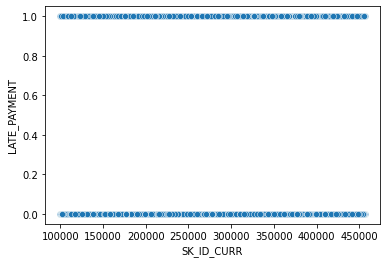

In [56]:
sns.scatterplot(x='SK_ID_CURR', y='LATE_PAYMENT', data=df_pos_cash_bal);

Por fim, a base está devidamente tratada, com apenas uma ocorrência para cada ID_PREV, podendo então ser mesclada com as demais bases tratadas anteriormente

Seguindo, vamos importar e analisar a base de dados 'previous_application'

### PREVIOUS_APPLICATION - RESULTANTE

In [57]:
df_previous_application = pd.read_csv('./datasets_trabalho/previous_application.csv')
df_test = pd.read_csv('./datasets_trabalho/application_test_student.csv')
df_train = pd.read_csv('./datasets_trabalho/application_train.csv')

In [58]:
info(df_previous_application)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

None

object     16
float64    15
int64       6
dtype: int64

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.000,17145.000,0.000,17145.000,SATURDAY,15,Y,1,0.000,0.183,0.867,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.000,middle,POS mobile with interest,365243.000,-42.000,300.000,-42.000,-37.000,0.000
1,2802425,108129,Cash loans,25188.615,607500.000,679671.000,NaN,607500.000,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.000,low_action,Cash X-Sell: low,365243.000,-134.000,916.000,365243.000,365243.000,1.000
2,2523466,122040,Cash loans,15060.735,112500.000,136444.500,NaN,112500.000,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.000,high,Cash X-Sell: high,365243.000,-271.000,59.000,365243.000,365243.000,1.000
3,2819243,176158,Cash loans,47041.335,450000.000,470790.000,NaN,450000.000,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.000,middle,Cash X-Sell: middle,365243.000,-482.000,-152.000,-182.000,-177.000,1.000
4,1784265,202054,Cash loans,31924.395,337500.000,404055.000,NaN,337500.000,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


['SK_ID_PREV' 'SK_ID_CURR' 'NAME_CONTRACT_TYPE' 'AMT_ANNUITY'
 'AMT_APPLICATION' 'AMT_CREDIT' 'AMT_DOWN_PAYMENT' 'AMT_GOODS_PRICE'
 'WEEKDAY_APPR_PROCESS_START' 'HOUR_APPR_PROCESS_START'
 'FLAG_LAST_APPL_PER_CONTRACT' 'NFLAG_LAST_APPL_IN_DAY'
 'RATE_DOWN_PAYMENT' 'RATE_INTEREST_PRIMARY' 'RATE_INTEREST_PRIVILEGED'
 'NAME_CASH_LOAN_PURPOSE' 'NAME_CONTRACT_STATUS' 'DAYS_DECISION'
 'NAME_PAYMENT_TYPE' 'CODE_REJECT_REASON' 'NAME_TYPE_SUITE'
 'NAME_CLIENT_TYPE' 'NAME_GOODS_CATEGORY' 'NAME_PORTFOLIO'
 'NAME_PRODUCT_TYPE' 'CHANNEL_TYPE' 'SELLERPLACE_AREA'
 'NAME_SELLER_INDUSTRY' 'CNT_PAYMENT' 'NAME_YIELD_GROUP'
 'PRODUCT_COMBINATION' 'DAYS_FIRST_DRAWING' 'DAYS_FIRST_DUE'
 'DAYS_LAST_DUE_1ST_VERSION' 'DAYS_LAST_DUE' 'DAYS_TERMINATION'
 'NFLAG_INSURED_ON_APPROVAL']


In [59]:
missing(df_previous_application)

,Qtd,Qtd %
SK_ID_PREV,0,0.0%
SK_ID_CURR,0,0.0%
NAME_CONTRACT_TYPE,0,0.0%
AMT_ANNUITY,372235,3.4%
AMT_APPLICATION,0,0.0%
AMT_CREDIT,1,0.0%
AMT_DOWN_PAYMENT,895844,8.1%
AMT_GOODS_PRICE,385515,3.5%
WEEKDAY_APPR_PROCESS_START,0,0.0%
HOUR_APPR_PROCESS_START,0,0.0%


Antes de fazer o tratamento dos dados, será feito o join deste dataset com os datasets limpos anteriormente, e o trabalho será no dataset resultante:

In [60]:
df_previous_application = df_installments_payments.merge(df_previous_application,on=['SK_ID_PREV'], how='right')
df_previous_application.shape

(1670214, 41)

In [61]:
missing(df_previous_application)

,Qtd,Qtd %
SK_ID_PREV,0,0.0%
SK_ID_CURR_x,711309,5.1%
DAYS_BALANCE,711309,5.1%
AMT_INSTALMENT,711309,5.1%
AMT_UNPAID,711309,5.1%
SK_ID_CURR_y,0,0.0%
NAME_CONTRACT_TYPE,0,0.0%
AMT_ANNUITY,372235,2.7%
AMT_APPLICATION,0,0.0%
AMT_CREDIT,1,0.0%


Será realizado um join pela mesma feature SK_ID_PREV, e devido à grande disparidade de dados, será realizado um left join, para manter os dados existentes na base que resultou das demais uniões:

In [62]:
df_previous_application.drop('SK_ID_CURR_x',axis='columns',inplace=True)
df_previous_application = df_previous_application.rename(columns={'SK_ID_CURR_y':'SK_ID_CURR'})
df_previous_application = df_previous_application.merge(df_credit_card_balance,on=['SK_ID_PREV'], how='left')
df_previous_application.head()

,SK_ID_PREV,DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID,SK_ID_CURR_x,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,...,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,SK_ID_CURR_y,PAYMENT_BALANCE,SK_DPD,DRAW_BALANCE,DEBT_RATIO
0,2030495,0.000,17284.275,0.000,271877,Consumer loans,1730.430,17145.000,17145.000,0.000,...,-42.000,300.000,-42.000,-37.000,0.000,NaN,NaN,NaN,NaN,NaN
1,2802425,-46.000,125943.075,0.000,108129,Cash loans,25188.615,607500.000,679671.000,NaN,...,-134.000,916.000,365243.000,365243.000,1.000,NaN,NaN,NaN,NaN,NaN
2,2523466,-74.000,135546.615,0.000,122040,Cash loans,15060.735,112500.000,136444.500,NaN,...,-271.000,59.000,365243.000,365243.000,1.000,NaN,NaN,NaN,NaN,NaN
3,2819243,-78.000,563133.375,0.000,176158,Cash loans,47041.335,450000.000,470790.000,NaN,...,-482.000,-152.000,-182.000,-177.000,1.000,NaN,NaN,NaN,NaN,NaN
4,1784265,NaN,NaN,NaN,202054,Cash loans,31924.395,337500.000,404055.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df_previous_application.drop('SK_ID_CURR_y',axis='columns',inplace=True)
df_previous_application = df_previous_application.rename(columns={'SK_ID_CURR_x':'SK_ID_CURR'})

Por fim, será realizado um join com a database 'POS_CASH_BALANCE', também pela feature SK_ID_PREV:

In [64]:
df_previous_application = df_previous_application.merge(df_pos_cash_bal,on=['SK_ID_PREV'], how='left')
df_previous_application.drop('SK_ID_CURR_y',axis='columns',inplace=True)
df_previous_application.rename(columns={'SK_ID_CURR_x':'SK_ID_CURR','SK_DPD_x':'CC_DPD','SK_DPD_y':'POS_DPD'},inplace=True)
df_previous_application.head()


,SK_ID_PREV,DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,...,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,PAYMENT_BALANCE,CC_DPD,DRAW_BALANCE,DEBT_RATIO,POS_DPD,EARLY_PAYMENT,LATE_PAYMENT
0,2030495,0.000,17284.275,0.000,271877,Consumer loans,1730.430,17145.000,17145.000,0.000,...,-42.000,-37.000,0.000,NaN,NaN,NaN,NaN,0.000,1.000,0.000
1,2802425,-46.000,125943.075,0.000,108129,Cash loans,25188.615,607500.000,679671.000,NaN,...,365243.000,365243.000,1.000,NaN,NaN,NaN,NaN,0.000,1.000,0.000
2,2523466,-74.000,135546.615,0.000,122040,Cash loans,15060.735,112500.000,136444.500,NaN,...,365243.000,365243.000,1.000,NaN,NaN,NaN,NaN,0.000,1.000,0.000
3,2819243,-78.000,563133.375,0.000,176158,Cash loans,47041.335,450000.000,470790.000,NaN,...,-182.000,-177.000,1.000,NaN,NaN,NaN,NaN,0.000,1.000,0.000
4,1784265,NaN,NaN,NaN,202054,Cash loans,31924.395,337500.000,404055.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
missing(df_previous_application)

,Qtd,Qtd %
SK_ID_PREV,0,0.0%
DAYS_BALANCE,711309,3.3%
AMT_INSTALMENT,711309,3.3%
AMT_UNPAID,711309,3.3%
SK_ID_CURR,0,0.0%
NAME_CONTRACT_TYPE,0,0.0%
AMT_ANNUITY,372235,1.7%
AMT_APPLICATION,0,0.0%
AMT_CREDIT,1,0.0%
AMT_DOWN_PAYMENT,895844,4.1%


Será então realizado o tratamento do dataset resultante, visando manter apenas um registro para cada 'ID_CURR'. 

A quantidade de parcelas acordadas no crédito, destacada na feature 'CNT_PAYMENT', será dividida em 3 categorias: 'SHORT_TERM' - 0 a 12 meses, 'MID_TERM' - 12 a 36 meses, 'LONG_TERM' - mais de 36 meses. Essa feature será posteriormente dividida em dummies, que auxiliarão na contagem da quantidade de empréstimo de cada tipo para cada cliente.

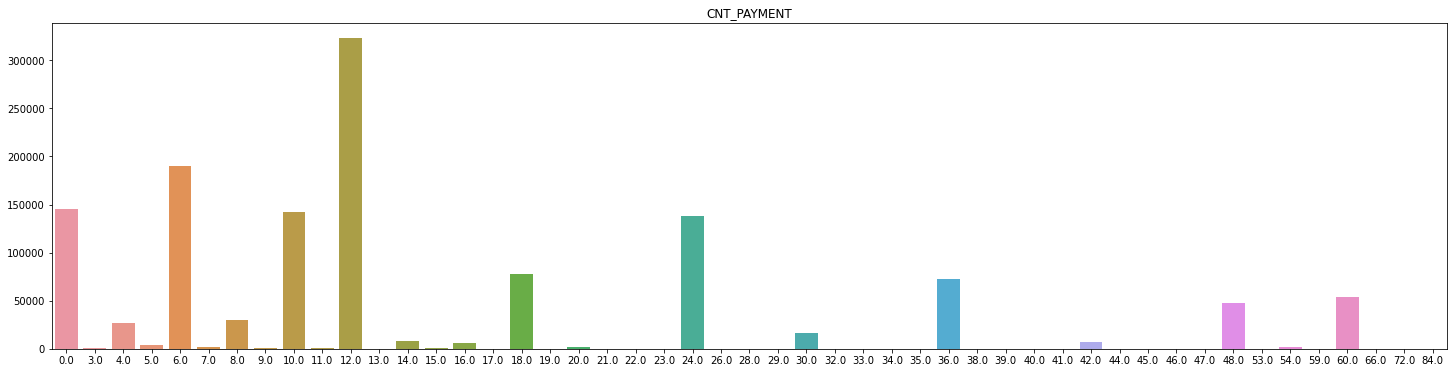

,CNT_PAYMENT,CNT_PAYMENT %
12.000,323049,24.9%
6.000,190461,14.7%
0.000,144985,11.2%
10.000,141851,10.9%
24.000,137764,10.6%
18.000,77430,6.0%
36.000,72583,5.6%
60.000,53600,4.1%
48.000,47316,3.6%
8.000,30349,2.3%


In [66]:
contagem_cat(df_previous_application, 'CNT_PAYMENT', size = [25, 6])

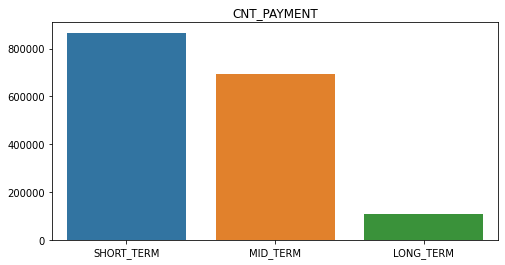

,CNT_PAYMENT,CNT_PAYMENT %
SHORT_TERM,866015,51.9%
MID_TERM,693826,41.5%
LONG_TERM,110373,6.6%


In [67]:
df_previous_application['CNT_PAYMENT'] = df_previous_application['CNT_PAYMENT'].apply(lambda x: 'SHORT_TERM' if x<=12 else('LONG_TERM' if x>36 else 'MID_TERM'))
contagem_cat(df_previous_application, 'CNT_PAYMENT')

O próximo passo é dropar as colunas irrelevantes ou que dificilmente poderão ser implementadas em uma análise que agrupe os dados ao longo do tempo, por exemplo categóricas com muitas opções ou com dados válidos apenas para aquela observação particular.

In [68]:
columns_drop = ['AMT_GOODS_PRICE','WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START','FLAG_LAST_APPL_PER_CONTRACT','RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED','AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT','DAYS_TERMINATION','DAYS_FIRST_DRAWING',
    'DAYS_FIRST_DUE','DAYS_LAST_DUE','DAYS_LAST_DUE_1ST_VERSION','CODE_REJECT_REASON','NAME_CASH_LOAN_PURPOSE','NAME_TYPE_SUITE','NAME_CLIENT_TYPE','NAME_GOODS_CATEGORY','NAME_PORTFOLIO','DAYS_DECISION','NAME_PAYMENT_TYPE','NAME_PRODUCT_TYPE',
    'SELLERPLACE_AREA','NAME_SELLER_INDUSTRY','NAME_YIELD_GROUP','PRODUCT_COMBINATION','NFLAG_INSURED_ON_APPROVAL','NFLAG_LAST_APPL_IN_DAY','CHANNEL_TYPE']
df_previous_application.drop(columns_drop,axis='columns',inplace=True)
info(df_previous_application)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1670214 entries, 0 to 1670213
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   SK_ID_PREV            1670214 non-null  int64  
 1   DAYS_BALANCE          958905 non-null   float64
 2   AMT_INSTALMENT        958905 non-null   float64
 3   AMT_UNPAID            958905 non-null   float64
 4   SK_ID_CURR            1670214 non-null  int64  
 5   NAME_CONTRACT_TYPE    1670214 non-null  object 
 6   AMT_ANNUITY           1297979 non-null  float64
 7   AMT_APPLICATION       1670214 non-null  float64
 8   AMT_CREDIT            1670213 non-null  float64
 9   NAME_CONTRACT_STATUS  1670214 non-null  object 
 10  CNT_PAYMENT           1670214 non-null  object 
 11  PAYMENT_BALANCE       92935 non-null    float64
 12  CC_DPD                92935 non-null    float64
 13  DRAW_BALANCE          92935 non-null    float64
 14  DEBT_RATIO            92935 non-nu

None

float64    13
object      3
int64       2
dtype: int64

,SK_ID_PREV,DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,NAME_CONTRACT_STATUS,CNT_PAYMENT,PAYMENT_BALANCE,CC_DPD,DRAW_BALANCE,DEBT_RATIO,POS_DPD,EARLY_PAYMENT,LATE_PAYMENT
0,2030495,0.000,17284.275,0.000,271877,Consumer loans,1730.430,17145.000,17145.000,Approved,SHORT_TERM,NaN,NaN,NaN,NaN,0.000,1.000,0.000
1,2802425,-46.000,125943.075,0.000,108129,Cash loans,25188.615,607500.000,679671.000,Approved,MID_TERM,NaN,NaN,NaN,NaN,0.000,1.000,0.000
2,2523466,-74.000,135546.615,0.000,122040,Cash loans,15060.735,112500.000,136444.500,Approved,SHORT_TERM,NaN,NaN,NaN,NaN,0.000,1.000,0.000
3,2819243,-78.000,563133.375,0.000,176158,Cash loans,47041.335,450000.000,470790.000,Approved,SHORT_TERM,NaN,NaN,NaN,NaN,0.000,1.000,0.000
4,1784265,NaN,NaN,NaN,202054,Cash loans,31924.395,337500.000,404055.000,Refused,MID_TERM,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['SK_ID_PREV' 'DAYS_BALANCE' 'AMT_INSTALMENT' 'AMT_UNPAID' 'SK_ID_CURR'
 'NAME_CONTRACT_TYPE' 'AMT_ANNUITY' 'AMT_APPLICATION' 'AMT_CREDIT'
 'NAME_CONTRACT_STATUS' 'CNT_PAYMENT' 'PAYMENT_BALANCE' 'CC_DPD'
 'DRAW_BALANCE' 'DEBT_RATIO' 'POS_DPD' 'EARLY_PAYMENT' 'LATE_PAYMENT']


Em sequência, serão dropadas observações nas quais a quantidade aplicada é zero e os dados de anuidade são NaN, por possivelmente se tratarem de erros no cadastro. Depois, os valores restantes marcados como 'Canceled' ou 'Unused offer' na feature 'NAME_CONTRACT_STATUS' serão renomeados para 'Approved', uma vez que são créditos aprovados, mas cancelados ou não usados posteriormente.

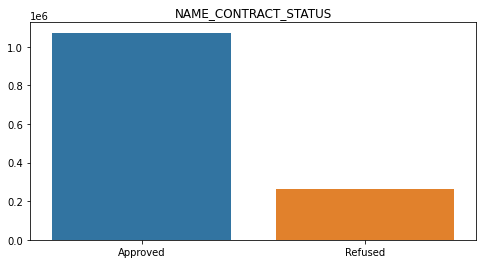

,NAME_CONTRACT_STATUS,NAME_CONTRACT_STATUS %
Approved,1073478,80.4%
Refused,261590,19.6%


In [69]:
df_previous_application.drop(df_previous_application.loc[(df_previous_application['AMT_APPLICATION']==0) & (df_previous_application['AMT_ANNUITY'].isna())].index, inplace=True)
df_previous_application['NAME_CONTRACT_STATUS'] = df_previous_application['NAME_CONTRACT_STATUS'].replace(['Canceled', 'Unused offer'], 'Approved')
contagem_cat(df_previous_application, 'NAME_CONTRACT_STATUS')


Agora, serão criadas Dummies para as features categóricas restantes: 'NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS' e 'CNT_PAYMENT'. Com isso será possível fazer uma análise quantitativa através do tempo, com a quantidade de contratos de cada tipo, a quantidade de contratos aceitos ou rejeitados e a duração dos contratos de cada cliente. Por fim, será dropada a coluna 'SK_ID_PREV', uma vez que deste ponto em diante os clientes serão unidos apenas pela feature 'SK_ID_CURR'

In [70]:
df_previous_application = pd.get_dummies(df_previous_application, columns = ['NAME_CONTRACT_TYPE','NAME_CONTRACT_STATUS','CNT_PAYMENT'])
df_previous_application.rename(columns={'NAME_CONTRACT_TYPE_Cash loans':'QTY_CASH_LOANS','NAME_CONTRACT_TYPE_Consumer loans':'QTY_CONSUMER_LOANS','NAME_CONTRACT_TYPE_Revolving loans':'QTY_REVOLVING_LOANS','NAME_CONTRACT_STATUS_Approved':'QTY_APPROVED_CONTRACTS','NAME_CONTRACT_STATUS_Refused':'QTY_REFUSED_CONTRACTS',
                                        'CNT_PAYMENT_SHORT_TERM':'QTY_SHORT_TERM_CONTRACTS','CNT_PAYMENT_MID_TERM':'QTY_MID_TERM_CONTRACTS','CNT_PAYMENT_LONG_TERM':'QTY_LONG_TERM_CONTRACTS','DAYS_BALANCE':'INSTALMENT_PAYMENT_DAYS_BALANCE','AMT_UNPAID':'AMT_UNPAID_INSTALMENTS','AMT_ANNUITY':'AMT_CREDIT_ANNUITY',
                                        'PAYMENT_BALANCE':'CC_PAYMENT_BALANCE','DRAW_BALANCE':'CC_DRAW_BALANCE','DEBT_RATIO':'CC_DEBT_RATE','EARLY_PAYMENT':'POS_EARLY_PAYMENT','LATE_PAYMENT':'POS_LATE_PAYMENT','AMT_APPLICATION':'AMT_CREDIT_APPLICATION','AMT_CREDIT':'AMT_CREDIT_GIVEN'},inplace=True)
df_previous_application.drop('SK_ID_PREV',axis='columns',inplace=True)

In [71]:
info(df_previous_application)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1335068 entries, 0 to 1670213
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   INSTALMENT_PAYMENT_DAYS_BALANCE  958905 non-null   float64
 1   AMT_INSTALMENT                   958905 non-null   float64
 2   AMT_UNPAID_INSTALMENTS           958905 non-null   float64
 3   SK_ID_CURR                       1335068 non-null  int64  
 4   AMT_CREDIT_ANNUITY               1297979 non-null  float64
 5   AMT_CREDIT_APPLICATION           1335068 non-null  float64
 6   AMT_CREDIT_GIVEN                 1335067 non-null  float64
 7   CC_PAYMENT_BALANCE               92935 non-null    float64
 8   CC_DPD                           92935 non-null    float64
 9   CC_DRAW_BALANCE                  92935 non-null    float64
 10  CC_DEBT_RATE                     92935 non-null    float64
 11  POS_DPD                          897068 non-null  

None

float64    13
uint8       8
int64       1
dtype: int64

,INSTALMENT_PAYMENT_DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID_INSTALMENTS,SK_ID_CURR,AMT_CREDIT_ANNUITY,AMT_CREDIT_APPLICATION,AMT_CREDIT_GIVEN,CC_PAYMENT_BALANCE,CC_DPD,CC_DRAW_BALANCE,CC_DEBT_RATE,POS_DPD,POS_EARLY_PAYMENT,POS_LATE_PAYMENT,QTY_CASH_LOANS,QTY_CONSUMER_LOANS,QTY_REVOLVING_LOANS,QTY_APPROVED_CONTRACTS,QTY_REFUSED_CONTRACTS,QTY_LONG_TERM_CONTRACTS,QTY_MID_TERM_CONTRACTS,QTY_SHORT_TERM_CONTRACTS
0,0.000,17284.275,0.000,271877,1730.430,17145.000,17145.000,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0,1,0,1,0,0,0,1
1,-46.000,125943.075,0.000,108129,25188.615,607500.000,679671.000,NaN,NaN,NaN,NaN,0.000,1.000,0.000,1,0,0,1,0,0,1,0
2,-74.000,135546.615,0.000,122040,15060.735,112500.000,136444.500,NaN,NaN,NaN,NaN,0.000,1.000,0.000,1,0,0,1,0,0,0,1
3,-78.000,563133.375,0.000,176158,47041.335,450000.000,470790.000,NaN,NaN,NaN,NaN,0.000,1.000,0.000,1,0,0,1,0,0,0,1
4,NaN,NaN,NaN,202054,31924.395,337500.000,404055.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,1,0


['INSTALMENT_PAYMENT_DAYS_BALANCE' 'AMT_INSTALMENT'
 'AMT_UNPAID_INSTALMENTS' 'SK_ID_CURR' 'AMT_CREDIT_ANNUITY'
 'AMT_CREDIT_APPLICATION' 'AMT_CREDIT_GIVEN' 'CC_PAYMENT_BALANCE' 'CC_DPD'
 'CC_DRAW_BALANCE' 'CC_DEBT_RATE' 'POS_DPD' 'POS_EARLY_PAYMENT'
 'POS_LATE_PAYMENT' 'QTY_CASH_LOANS' 'QTY_CONSUMER_LOANS'
 'QTY_REVOLVING_LOANS' 'QTY_APPROVED_CONTRACTS' 'QTY_REFUSED_CONTRACTS'
 'QTY_LONG_TERM_CONTRACTS' 'QTY_MID_TERM_CONTRACTS'
 'QTY_SHORT_TERM_CONTRACTS']


Será feito então o agrupamento de todas as observações pelo 'ID_CURR'. A feature 'DEBT_RATE' será mantida com a média das observações válidas, enquanto as features 'POS_LATE_PAYMENT' e 'POS_EARLY_PAYMENT' serão mantidas com o valor máximo, para manter resultados binários (0 ou 1). As demais serão somadas.

In [72]:
df_previous_application = df_previous_application.groupby('SK_ID_CURR', as_index = False, sort = False).agg(
    {'INSTALMENT_PAYMENT_DAYS_BALANCE':'sum','AMT_INSTALMENT':'sum','AMT_UNPAID_INSTALMENTS':'sum','AMT_CREDIT_ANNUITY':'sum','AMT_CREDIT_APPLICATION':'sum','AMT_CREDIT_GIVEN':'sum','CC_PAYMENT_BALANCE':'sum','CC_DPD':'sum','CC_DRAW_BALANCE':'sum','POS_DPD':'sum','QTY_CASH_LOANS':'sum','QTY_CONSUMER_LOANS':'sum','QTY_REVOLVING_LOANS':'sum','QTY_APPROVED_CONTRACTS':'sum',
    'QTY_REFUSED_CONTRACTS':'sum','QTY_LONG_TERM_CONTRACTS':'sum','QTY_MID_TERM_CONTRACTS':'sum','QTY_SHORT_TERM_CONTRACTS':'sum','CC_DEBT_RATE':'mean','POS_EARLY_PAYMENT':'max','POS_LATE_PAYMENT':'max'})
df_previous_application.head()

,SK_ID_CURR,INSTALMENT_PAYMENT_DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID_INSTALMENTS,AMT_CREDIT_ANNUITY,AMT_CREDIT_APPLICATION,AMT_CREDIT_GIVEN,CC_PAYMENT_BALANCE,CC_DPD,CC_DRAW_BALANCE,...,QTY_CONSUMER_LOANS,QTY_REVOLVING_LOANS,QTY_APPROVED_CONTRACTS,QTY_REFUSED_CONTRACTS,QTY_LONG_TERM_CONTRACTS,QTY_MID_TERM_CONTRACTS,QTY_SHORT_TERM_CONTRACTS,CC_DEBT_RATE,POS_EARLY_PAYMENT,POS_LATE_PAYMENT
0,271877,-78.000,141675.525,0.000,82406.475,1925545.500,1891714.500,0.000,0.000,0.000,...,3,0,2,1,0,1,2,NaN,1.000,0.000
1,108129,-520.000,1237009.815,0.000,78236.910,1209154.500,1545133.500,261253.890,0.000,0.000,...,3,1,6,0,0,2,4,0.065,1.000,0.000
2,122040,-414.000,394255.485,0.000,28869.345,266760.000,290785.500,45159.975,0.000,0.000,...,1,1,3,0,0,0,3,0.013,1.000,0.000
3,176158,-513.000,2860328.745,-0.000,588473.685,5973214.950,6269305.500,0.000,0.000,0.000,...,1,0,6,15,0,7,14,NaN,1.000,0.000
4,202054,-499.000,1130947.650,-0.000,360189.675,4475943.000,5201541.000,-39940.965,0.000,3577.680,...,6,1,8,9,0,11,6,0.800,1.000,1.000


In [73]:
missing(df_previous_application)

,Qtd,Qtd %
SK_ID_CURR,0,0.0%
INSTALMENT_PAYMENT_DAYS_BALANCE,0,0.0%
AMT_INSTALMENT,0,0.0%
AMT_UNPAID_INSTALMENTS,0,0.0%
AMT_CREDIT_ANNUITY,0,0.0%
AMT_CREDIT_APPLICATION,0,0.0%
AMT_CREDIT_GIVEN,0,0.0%
CC_PAYMENT_BALANCE,0,0.0%
CC_DPD,0,0.0%
CC_DRAW_BALANCE,0,0.0%


No dataset resultante, podemos encontrar várias informações úteis: A quantidade de créditos solicitados de cada tipo por cliente, quantos foram reprovados e quantos foram aprovados, e quantos são de pequeno, médio e longo prazo. É possível verificar também a taxa de inadimplência nas faturas de cartão de crédito ('CC_DEBT_RATE'), enquanto que os valores que permanecem como NaN's nesta feature representam clientes que não possuem cartão de crédito, e os valores NaN's nas features de pagamento adiantado ou atrasado para a compra de bens, são de clientes que não registraram a compra de bens.

Para finalizar as sub-bases, será unida a base resultante com a base bureau:

### RESULTING (MERGE ENTRE OS DFs 'PREVIOUS APPLICATION' E 'BUREAU')

In [74]:
df_res = df_previous_application.merge(df_bureau,on=['SK_ID_CURR'], how='left')
df_res.head()

,SK_ID_CURR,INSTALMENT_PAYMENT_DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID_INSTALMENTS,AMT_CREDIT_ANNUITY,AMT_CREDIT_APPLICATION,AMT_CREDIT_GIVEN,CC_PAYMENT_BALANCE,CC_DPD,CC_DRAW_BALANCE,...,CC_DEBT_RATE,POS_EARLY_PAYMENT,POS_LATE_PAYMENT,SK_ID_BUREAU,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,BUREAU_CURRENT_SUM_OVERDUE,N_ACTIVE_CREDITS_BUREAU,N_CLOSED_CREDITS_BUREAU,DEFAULT_RATE
0,271877,-78.000,141675.525,0.000,82406.475,1925545.500,1891714.500,0.000,0.000,0.000,...,NaN,1.000,0.000,24207090.000,0.000,183765.060,0.000,2.000,2.000,0.000
1,108129,-520.000,1237009.815,0.000,78236.910,1209154.500,1545133.500,261253.890,0.000,0.000,...,0.065,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,122040,-414.000,394255.485,0.000,28869.345,266760.000,290785.500,45159.975,0.000,0.000,...,0.013,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,176158,-513.000,2860328.745,-0.000,588473.685,5973214.950,6269305.500,0.000,0.000,0.000,...,NaN,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,202054,-499.000,1130947.650,-0.000,360189.675,4475943.000,5201541.000,-39940.965,0.000,3577.680,...,0.800,1.000,1.000,73827906.000,0.000,755153.550,0.000,1.000,11.000,0.833


Um rápido tratamento será realizado nas features do dataset resultante para melhor compreensão:

In [75]:
df_res.drop('SK_ID_BUREAU', axis='columns',inplace=True)
df_res.rename(columns={'CREDIT_DAY_OVERDUE':'BUREAU_DAYS_OVERDUE','AMT_CREDIT_SUM':'BUREAU_CREDIT_SUM','BUREAU_CURRENT_SUM_OVERDUE':'BUREAU_SUM_OVERDUE','DEFAULT_RATE':'BUREAU_DEFAULT_RATE'},inplace=True)
df_res.head()

,SK_ID_CURR,INSTALMENT_PAYMENT_DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID_INSTALMENTS,AMT_CREDIT_ANNUITY,AMT_CREDIT_APPLICATION,AMT_CREDIT_GIVEN,CC_PAYMENT_BALANCE,CC_DPD,CC_DRAW_BALANCE,...,QTY_SHORT_TERM_CONTRACTS,CC_DEBT_RATE,POS_EARLY_PAYMENT,POS_LATE_PAYMENT,BUREAU_DAYS_OVERDUE,BUREAU_CREDIT_SUM,BUREAU_SUM_OVERDUE,N_ACTIVE_CREDITS_BUREAU,N_CLOSED_CREDITS_BUREAU,BUREAU_DEFAULT_RATE
0,271877,-78.000,141675.525,0.000,82406.475,1925545.500,1891714.500,0.000,0.000,0.000,...,2,NaN,1.000,0.000,0.000,183765.060,0.000,2.000,2.000,0.000
1,108129,-520.000,1237009.815,0.000,78236.910,1209154.500,1545133.500,261253.890,0.000,0.000,...,4,0.065,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
2,122040,-414.000,394255.485,0.000,28869.345,266760.000,290785.500,45159.975,0.000,0.000,...,3,0.013,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
3,176158,-513.000,2860328.745,-0.000,588473.685,5973214.950,6269305.500,0.000,0.000,0.000,...,14,NaN,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
4,202054,-499.000,1130947.650,-0.000,360189.675,4475943.000,5201541.000,-39940.965,0.000,3577.680,...,6,0.800,1.000,1.000,0.000,755153.550,0.000,1.000,11.000,0.833


Obtida então a união de todos os dados preenchidos nas bases inferiores, será realizada a união dos dados obtidos das bases resultantes com as bases de treino e de teste, com base na feature 'SK_ID_CURR'.

### TRAIN e TEST

In [76]:
df_res_train = df_res.loc[df_res['SK_ID_CURR'].isin(df_train['SK_ID_CURR'])]
df_res_test = df_res.loc[df_res['SK_ID_CURR'].isin(df_test['SK_ID_CURR'])]

In [77]:
df_train = df_train.merge(df_res_train, on='SK_ID_CURR', how='left')

In [78]:
info(df_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 0 to 246007
Columns: 149 entries, SK_ID_CURR to BUREAU_DEFAULT_RATE
dtypes: float64(92), int64(41), object(16)
memory usage: 281.5+ MB


None

float64    92
int64      41
object     16
dtype: int64

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,INSTALMENT_PAYMENT_DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID_INSTALMENTS,AMT_CREDIT_ANNUITY,AMT_CREDIT_APPLICATION,AMT_CREDIT_GIVEN,CC_PAYMENT_BALANCE,CC_DPD,CC_DRAW_BALANCE,POS_DPD,QTY_CASH_LOANS,QTY_CONSUMER_LOANS,QTY_REVOLVING_LOANS,QTY_APPROVED_CONTRACTS,QTY_REFUSED_CONTRACTS,QTY_LONG_TERM_CONTRACTS,QTY_MID_TERM_CONTRACTS,QTY_SHORT_TERM_CONTRACTS,CC_DEBT_RATE,POS_EARLY_PAYMENT,POS_LATE_PAYMENT,BUREAU_DAYS_OVERDUE,BUREAU_CREDIT_SUM,BUREAU_SUM_OVERDUE,N_ACTIVE_CREDITS_BUREAU,N_CLOSED_CREDITS_BUREAU,BUREAU_DEFAULT_RATE
0,456162,0,Cash loans,F,N,N,0,112500.000,700830.000,22738.500,585000.000,Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.020,-8676,-813,-4163.000,-1363,NaN,1,1,1,1,0,0,Core staff,1.000,2,2,FRIDAY,17,0,0,0,1,1,0,Trade: type 2,NaN,0.699,0.171,0.062,0.030,0.976,0.674,0.005,0.000,0.103,0.167,0.042,0.000,0.050,0.051,0.000,0.000,0.063,0.031,0.976,0.686,0.005,0.000,0.103,0.167,0.042,0.000,0.055,0.053,0.000,0.000,0.062,0.030,0.976,0.678,0.005,0.000,0.103,0.167,0.042,0.000,0.051,0.052,0.000,0.000,reg oper account,block of flats,0.040,Block,No,0.000,0.000,0.000,0.000,-589.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000,-11.000,29759.220,0.000,4960.080,38430.000,27054.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,134978,0,Cash loans,F,N,N,0,90000.000,375322.500,14422.500,324000.000,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.025,-13583,-223,-3554.000,-3287,NaN,1,1,0,1,0,0,High skill tech staff,2.000,2,2,MONDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.541,0.200,0.769,0.023,0.057,0.981,0.735,0.016,0.000,0.103,0.042,0.083,0.013,0.018,0.018,0.000,0.000,0.023,0.059,0.981,0.745,0.016,0.000,

['SK_ID_CURR' 'TARGET' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTRANCES_AVG' 'FLOOR

In [79]:
df_test = df_test.merge(df_res_test, on='SK_ID_CURR', how='left')

In [80]:
info(df_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61503 entries, 0 to 61502
Columns: 148 entries, SK_ID_CURR to BUREAU_DEFAULT_RATE
dtypes: float64(92), int64(40), object(16)
memory usage: 69.9+ MB


None

float64    92
int64      40
object     16
dtype: int64

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,INSTALMENT_PAYMENT_DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID_INSTALMENTS,AMT_CREDIT_ANNUITY,AMT_CREDIT_APPLICATION,AMT_CREDIT_GIVEN,CC_PAYMENT_BALANCE,CC_DPD,CC_DRAW_BALANCE,POS_DPD,QTY_CASH_LOANS,QTY_CONSUMER_LOANS,QTY_REVOLVING_LOANS,QTY_APPROVED_CONTRACTS,QTY_REFUSED_CONTRACTS,QTY_LONG_TERM_CONTRACTS,QTY_MID_TERM_CONTRACTS,QTY_SHORT_TERM_CONTRACTS,CC_DEBT_RATE,POS_EARLY_PAYMENT,POS_LATE_PAYMENT,BUREAU_DAYS_OVERDUE,BUREAU_CREDIT_SUM,BUREAU_SUM_OVERDUE,N_ACTIVE_CREDITS_BUREAU,N_CLOSED_CREDITS_BUREAU,BUREAU_DEFAULT_RATE
0,149741,Cash loans,F,N,N,0,117000.000,417024.000,20191.500,360000.000,"Spouse, partner",Working,Incomplete higher,Married,House / apartment,0.020,-21774,-2125,-4611.000,-4653,NaN,1,1,1,1,1,0,Security staff,2.000,3,3,FRIDAY,13,0,0,0,0,0,0,Medicine,0.485,0.183,0.146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,0.000,1.000,0.000,-2008.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,3.000,192.000,134826.795,0.000,43623.765,666153.000,655591.500,0.000,0.000,0.000,916.000,0.000,2.000,1.000,1.000,2.000,0.000,1.000,2.000,NaN,0.000,1.000,0.000,2164757.220,0.000,4.000,6.000,0.500
1,363290,Cash loans,M,N,Y,0,450000.000,640080.000,31261.500,450000.000,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.046,-18499,-2055,-3052.000,-2028,NaN,1,1,0,1,0,0,Laborers,2.000,1,1,TUESDAY,13,0,0,0,0,0,0,Business Entity Type 3,0.625,0.669,0.680,0.376,0.448,0.995,NaN,NaN,0.480,0.207,0.625,NaN,0.035,NaN,0.459,NaN,0.005,0.383,0.465,0.995,NaN,NaN,0.483,0.207,0.625,NaN,0.035,NaN,0.478,NaN,0.005,0.380,0.448,0.995,NaN,NaN,0.480,0.207,0.625,NaN,0.035,NaN,0.467,NaN,0.005,NaN,block of flats,0.452

['SK_ID_CURR' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTRANCES_AVG' 'FLOORSMAX_AVG'

Agora vamos analisar alguns indicadores:

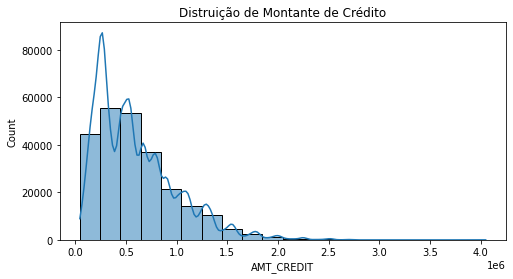

In [81]:
plot_num(df=df_train, col='AMT_CREDIT', title = 'Distruição de Montante de Crédito')

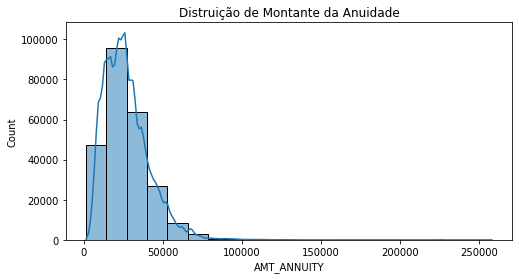

In [82]:
plot_num(df=df_train, col='AMT_ANNUITY', title = 'Distruição de Montante da Anuidade')

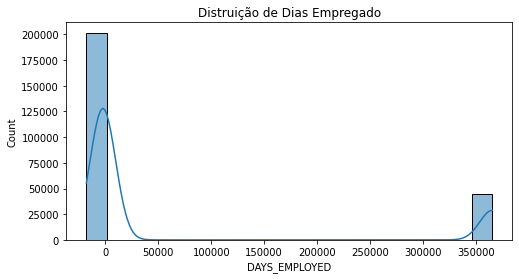

In [83]:
plot_num(df=df_train, col='DAYS_EMPLOYED', title = 'Distruição de Dias Empregado')

Percebe-se que as duas primeiras variáveis numéricas seguem distribuições bem definidas enquanto que "Days Employed" está divido em dois grande conjuntos, um para bons pagadores e o outro para inadimplentes, como ja era de se esperar.

Vamos analisar agora as variáveis categóricas:

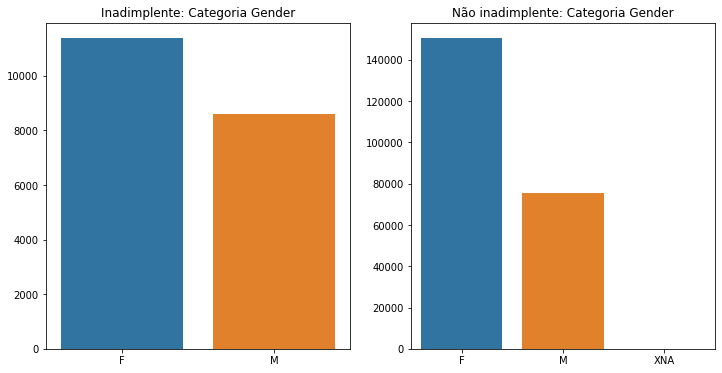

In [84]:
plot_cat2(df = df_train, col = 'CODE_GENDER', size = [12,6], title = 'Gender')

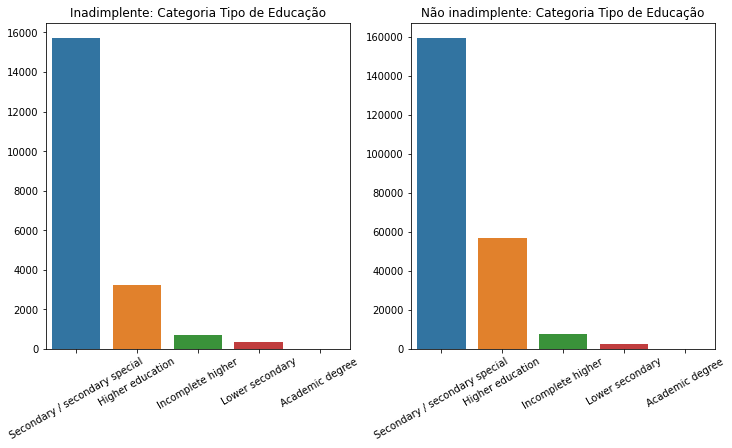

In [85]:
plot_cat2(df = df_train, col = 'NAME_EDUCATION_TYPE', size = [12,6], xlabel_angle = 30, title = 'Tipo de Educação')

As distribuições categóricas para os dois casos são pouco explicativas, o que não trás um primeiro insight à primeira vista.

Com base no aprendizado sobre as bases vamos propor a criação de duas features:

#### Crédito Total por Anuidade

Quanto mais crédito a pessoa tem por anuidade menor a dificuldade para honrar com os pagamentos.

In [86]:
df_train['Credito_Anuidade'] = df_train['AMT_CREDIT']/df_train['AMT_ANNUITY']
df_test['Credito_Anuidade'] = df_test['AMT_CREDIT']/df_test['AMT_ANNUITY']

#### Expectativa de Credito

Indicador muito utilizado para saber se a pessoa detém "capacidade de compra" sob o bem.

In [87]:
df_train['Expectativa_Credito'] = (df_train['AMT_CREDIT'] > df_train['AMT_GOODS_PRICE']).map({False:0, True:1})
df_test['Expectativa_Credito'] = (df_test['AMT_CREDIT'] > df_test['AMT_GOODS_PRICE']).map({False:0, True:1})

Obtidas as bases prontas para treino e teste, todos os datasets serão salvos como csv, para evitar a perda dos dados em caso de falha no kernel.

In [88]:
df_bureau.to_csv('df_bureau.csv')
df_credit_card_balance.to_csv('df_credit_card_balance.csv')
df_installments_payments.to_csv('df_installments_payments.csv')
df_previous_application.to_csv('df_previous_application.csv')
df_res.to_csv('df_res.csv')
df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

Finalmente, é possível dar início à fase de modelagem.

# MODELAGEM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVC
from skopt import BayesSearchCV
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Como salvamos as bases tratadas de treino e de teste, importaremos elas e os pacotes utilizados acima para que as duas partes do código sejam independentes

In [2]:
df_train = pd.read_csv('df_train.csv',index_col=0)
df_test = pd.read_csv('df_test.csv',index_col=0)

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,INSTALMENT_PAYMENT_DAYS_BALANCE,AMT_INSTALMENT,AMT_UNPAID_INSTALMENTS,AMT_CREDIT_ANNUITY,AMT_CREDIT_APPLICATION,AMT_CREDIT_GIVEN,CC_PAYMENT_BALANCE,CC_DPD,CC_DRAW_BALANCE,POS_DPD,QTY_CASH_LOANS,QTY_CONSUMER_LOANS,QTY_REVOLVING_LOANS,QTY_APPROVED_CONTRACTS,QTY_REFUSED_CONTRACTS,QTY_LONG_TERM_CONTRACTS,QTY_MID_TERM_CONTRACTS,QTY_SHORT_TERM_CONTRACTS,CC_DEBT_RATE,POS_EARLY_PAYMENT,POS_LATE_PAYMENT,BUREAU_DAYS_OVERDUE,BUREAU_CREDIT_SUM,BUREAU_SUM_OVERDUE,N_ACTIVE_CREDITS_BUREAU,N_CLOSED_CREDITS_BUREAU,BUREAU_DEFAULT_RATE,Credito_Anuidade,Expectativa_Credito
0,456162,0,Cash loans,F,N,N,0,112500.000,700830.000,22738.500,585000.000,Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.020,-8676,-813,-4163.000,-1363,NaN,1,1,1,1,0,0,Core staff,1.000,2,2,FRIDAY,17,0,0,0,1,1,0,Trade: type 2,NaN,0.699,0.171,0.062,0.030,0.976,0.674,0.005,0.000,0.103,0.167,0.042,0.000,0.050,0.051,0.000,0.000,0.063,0.031,0.976,0.686,0.005,0.000,0.103,0.167,0.042,0.000,0.055,0.053,0.000,0.000,0.062,0.030,0.976,0.678,0.005,0.000,0.103,0.167,0.042,0.000,0.051,0.052,0.000,0.000,reg oper account,block of flats,0.040,Block,No,0.000,0.000,0.000,0.000,-589.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000,-11.000,29759.220,0.000,4960.080,38430.000,27054.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,30.821,1
1,134978,0,Cash loans,F,N,N,0,90000.000,375322.500,14422.500,324000.000,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.025,-13583,-223,-3554.000,-3287,NaN,1,1,0,1,0,0,High skill tech staff,2.000,2,2,MONDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.541,0.200,0.769,0.023,0.057,0.981,0.735,0.016,0.000,0.103,0.042,0.083,0.013,0.018,0.018,0.

In [5]:
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243,0)

In [6]:
df_train.isna().sum()

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
                            ...  
N_ACTIVE_CREDITS_BUREAU    175139
N_CLOSED_CREDITS_BUREAU    175139
BUREAU_DEFAULT_RATE        175139
Credito_Anuidade               10
Expectativa_Credito             0
Length: 151, dtype: int64

Selecionamos então as columnas que serão tratadas de acordo com cada tipo de dado:

In [7]:
to_drop = ['NAME_TYPE_SUITE','OWN_CAR_AGE','OCCUPATION_TYPE','ORGANIZATION_TYPE','FONDKAPREMONT_MODE','HOUSETYPE_MODE','AMT_CREDIT','AMT_ANNUITY']
to_zero = ['BUREAU_DEFAULT_RATE','N_CLOSED_CREDITS_BUREAU','N_ACTIVE_CREDITS_BUREAU','BUREAU_SUM_OVERDUE','BUREAU_CREDIT_SUM','BUREAU_DAYS_OVERDUE','CC_DEBT_RATE','CC_DPD','CC_DRAW_BALANCE','CC_PAYMENT_BALANCE','AMT_UNPAID_INSTALMENTS','POS_DPD']
to_median = ['INSTALMENT_PAYMENT_DAYS_BALANCE','AMT_INSTALMENT','AMT_CREDIT_ANNUITY','AMT_CREDIT_APPLICATION','AMT_CREDIT_GIVEN']
to_mode = ['POS_LATE_PAYMENT','POS_EARLY_PAYMENT','QTY_SHORT_TERM_CONTRACTS','QTY_MID_TERM_CONTRACTS','QTY_LONG_TERM_CONTRACTS','QTY_REFUSED_CONTRACTS','QTY_APPROVED_CONTRACTS','QTY_REVOLVING_LOANS','QTY_CONSUMER_LOANS','QTY_CASH_LOANS']

In [8]:
df_train.drop(columns=to_drop, inplace=True)
df_test.drop(columns=to_drop, inplace=True)

Para evitar qualquer possibilidade de data leakage, já de início será realizado o Split entre bases de treino e teste (Tudo isso utilizando como base o df_train)

In [9]:
X = df_train.drop(columns = ['TARGET'])
y = df_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Tamanho do treino: ", X_train.shape)
print("Tamanho do teste: ", X_test.shape)

Tamanho do treino:  (172205, 142)
Tamanho do teste:  (73803, 142)


Vamos verificar como se comporta o target:

In [10]:
y.value_counts(normalize=True)

0   0.919
1   0.081
Name: TARGET, dtype: float64

Percebe-se um grande desbalanceamento entre as classes, o que faz necessário o uso de métodos de balanceamento. Sigamos com o pré-processamento.

In [11]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
num_cols_exclusive = [column for column in num_cols if (column not in to_zero) & (column not in to_median) & (column not in to_mode)]

Definimos então uma função para os pipelines de pré-processamento, que serão unidos nos pipelines de modelagem posteriores:

In [12]:
def preprocessor(zero_cols, median_cols, mode_cols, num_cols, cat_cols):
    
    pipe_transf_zero = Pipeline([
        ('input_zero', SimpleImputer(strategy='constant', fill_value=0, copy=False)),
        ('std', StandardScaler())
    ])

    pipe_transf_median = Pipeline([
        ('input_median', SimpleImputer(strategy='median', copy=False)),
        ('std', StandardScaler())
    ])
    
    pipe_transf_mode = Pipeline([
        ('input_mode', SimpleImputer(strategy='most_frequent', copy=False)),
        ('std', StandardScaler())
    ])

    pipe_transf_other = Pipeline([
        ('input_num', SimpleImputer(strategy='median', copy=False)),
        ('std', StandardScaler())     
    ])
    
    pipe_cat = Pipeline([
        ('input_cat', SimpleImputer(strategy='constant', fill_value='Unknown', copy=False)),
        ('onehot', OneHotEncoder(drop = 'first', sparse = False))        
    ])
       
    pipe_pre_processor = ColumnTransformer([
        ('transf_zero', pipe_transf_zero, zero_cols),
        ('transf_median', pipe_transf_median, median_cols),
        ('transf_mode', pipe_transf_mode, mode_cols),
        ('transf_other',pipe_transf_other, num_cols_exclusive),
        ('transf_cat', pipe_cat, cat_cols)       
    ])

    return pipe_pre_processor

def mostrar_metricas(estimador):

    print('Treino')
    y_pred_train = estimador.predict(X_train)
    ConfusionMatrixDisplay(confusion_matrix(y_train,y_pred_train)).plot()
    plt.show()
    print(classification_report(y_train, y_pred_train))
    
    print('Teste')
    y_pred_test = estimador.predict(X_test)
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_test)).plot()
    plt.show()
    print(classification_report(y_test, y_pred_test))

    return(classification_report(y_test,y_pred_test, output_dict=True))

Comportamento das bases de treino e teste antes do balanceamento:

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(172205, 142)
(172205,)
(73803, 142)
(73803,)


In [14]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0   0.919
1   0.081
Name: TARGET, dtype: float64
0   0.919
1   0.081
Name: TARGET, dtype: float64


In [15]:
oversampler = SMOTE(sampling_strategy = 0.15, random_state = 42)
undersampler = RandomUnderSampler(sampling_strategy = 0.33, random_state = 42)

pre_processor = preprocessor(to_zero, to_median, to_mode, num_cols, cat_cols)

X_train= pre_processor.fit_transform(X_train)
X_test = pre_processor.transform(X_test)
X_train,y_train = oversampler.fit_resample(X_train,y_train)
X_train,y_train = undersampler.fit_resample(X_train,y_train)

Comportamento das bases de treino e teste após o balanceamento:

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(95651, 172)
(95651,)
(73803, 172)
(73803,)


In [17]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0   0.752
1   0.248
Name: TARGET, dtype: float64
0   0.919
1   0.081
Name: TARGET, dtype: float64


Definimos então os modelos a serem testados, a fim de se determinar qual o melhor modelo para o estudo:

In [18]:
models = {
        'Tree' : DecisionTreeClassifier(random_state=42),
        'RandomForest' : RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(),
        'GradientBoost': GradientBoostingClassifier(random_state=42),
        'Adaboost': AdaBoostClassifier(random_state=42)}

Será então executado o código utilizando como base todos os modelos, sem o uso de rfe ou tuning de hiperparâmetros, para se verificar os resultados caso a caso:

Resultados modelo Tree
Treino


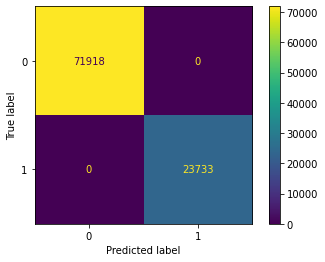

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71918
           1       1.00      1.00      1.00     23733

    accuracy                           1.00     95651
   macro avg       1.00      1.00      1.00     95651
weighted avg       1.00      1.00      1.00     95651

Teste


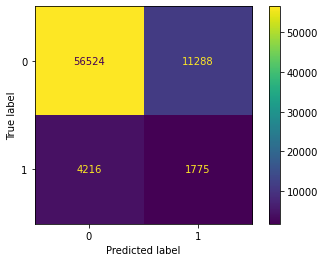

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     67812
           1       0.14      0.30      0.19      5991

    accuracy                           0.79     73803
   macro avg       0.53      0.56      0.53     73803
weighted avg       0.87      0.79      0.82     73803

Resultados modelo RandomForest
Treino


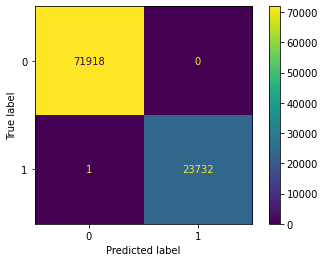

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71918
           1       1.00      1.00      1.00     23733

    accuracy                           1.00     95651
   macro avg       1.00      1.00      1.00     95651
weighted avg       1.00      1.00      1.00     95651

Teste


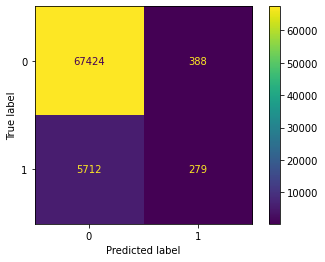

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     67812
           1       0.42      0.05      0.08      5991

    accuracy                           0.92     73803
   macro avg       0.67      0.52      0.52     73803
weighted avg       0.88      0.92      0.89     73803

Resultados modelo XGBoost
Treino


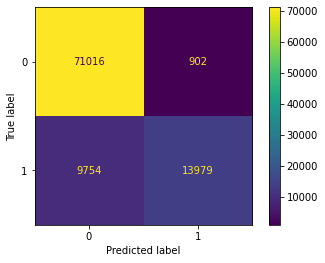

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     71918
           1       0.94      0.59      0.72     23733

    accuracy                           0.89     95651
   macro avg       0.91      0.79      0.83     95651
weighted avg       0.89      0.89      0.88     95651

Teste


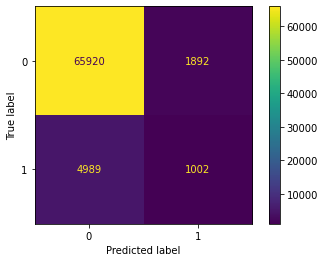

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     67812
           1       0.35      0.17      0.23      5991

    accuracy                           0.91     73803
   macro avg       0.64      0.57      0.59     73803
weighted avg       0.88      0.91      0.89     73803

Resultados modelo GradientBoost
Treino


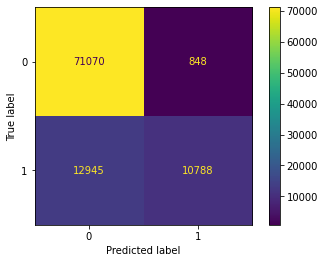

              precision    recall  f1-score   support

           0       0.85      0.99      0.91     71918
           1       0.93      0.45      0.61     23733

    accuracy                           0.86     95651
   macro avg       0.89      0.72      0.76     95651
weighted avg       0.87      0.86      0.84     95651

Teste


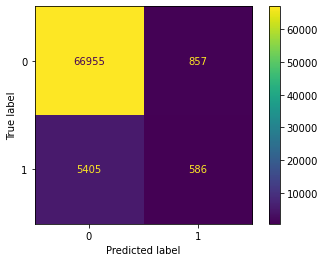

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     67812
           1       0.41      0.10      0.16      5991

    accuracy                           0.92     73803
   macro avg       0.67      0.54      0.56     73803
weighted avg       0.88      0.92      0.89     73803

Resultados modelo Adaboost
Treino


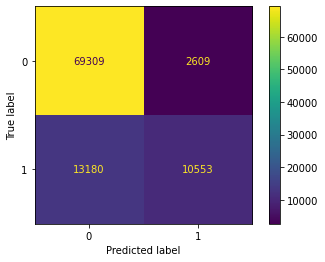

              precision    recall  f1-score   support

           0       0.84      0.96      0.90     71918
           1       0.80      0.44      0.57     23733

    accuracy                           0.83     95651
   macro avg       0.82      0.70      0.73     95651
weighted avg       0.83      0.83      0.82     95651

Teste


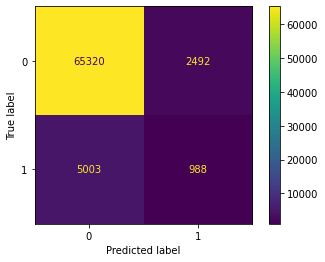

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     67812
           1       0.28      0.16      0.21      5991

    accuracy                           0.90     73803
   macro avg       0.61      0.56      0.58     73803
weighted avg       0.88      0.90      0.89     73803



In [19]:
models_results = {}
for model_name, model in models.items():

    model.fit(X_train, y_train)

    print('Resultados modelo',model_name)
    dict = mostrar_metricas(model)
    models_results[model_name] = [dict['0']['precision'],dict['0']['recall'],dict['0']['f1-score'],dict['1']['precision'],dict['1']['recall'],dict['1']['f1-score'],dict['accuracy']]

df_models_results = pd.DataFrame.from_dict(models_results,orient='columns').set_index(pd.Index(['0 Precision', '0 Recall', '0 F1-Score','1 Precision','1 Recall','1 F1-Score','Accuracy']))

In [45]:
df_models_results

,Tree,RandomForest,XGBoost,GradientBoost,Adaboost
0 Precision,0.931,0.922,0.930,0.925,0.929
0 Recall,0.834,0.994,0.972,0.987,0.963
0 F1-Score,0.879,0.957,0.950,0.955,0.946
1 Precision,0.136,0.418,0.346,0.406,0.284
1 Recall,0.296,0.047,0.167,0.098,0.165
1 F1-Score,0.186,0.084,0.226,0.158,0.209
Accuracy,0.790,0.917,0.907,0.915,0.898


O mesmo teste foi executado em outro momento utilizando todos os modelos em conjunto com o RFE. Devido ao grande tempo de execução, os resultados foram salvos em um arquivo .csv, e serão comparados em gráfico a seguir:

In [20]:
rfe_results = pd.read_csv('df_rfe_results.csv', index_col=0)

In [46]:
rfe_results

,Tree,RandomForest,XGBoost,GradientBoost,Adaboost
0 Precision,0.931,0.923,0.930,0.925,0.927
0 Recall,0.832,0.992,0.973,0.989,0.971
0 F1-Score,0.879,0.956,0.951,0.956,0.948
1 Precision,0.139,0.391,0.357,0.419,0.292
1 Recall,0.307,0.059,0.167,0.089,0.137
1 F1-Score,0.192,0.103,0.228,0.147,0.186
Accuracy,0.790,0.916,0.908,0.916,0.903


Percebe-se que em ambos os casos o melhor modelo num cenário geral foi o XGBoost. Por isso, este será o modelo adotado para executar o restante do modelo:

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Treino


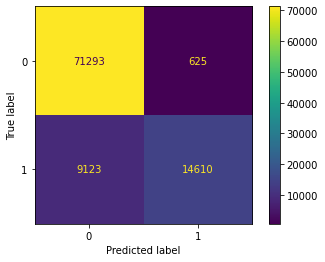

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     71918
           1       0.96      0.62      0.75     23733

    accuracy                           0.90     95651
   macro avg       0.92      0.80      0.84     95651
weighted avg       0.90      0.90      0.89     95651

Teste


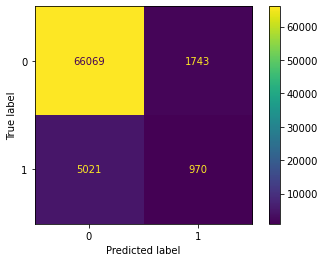

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     67812
           1       0.36      0.16      0.22      5991

    accuracy                           0.91     73803
   macro avg       0.64      0.57      0.59     73803
weighted avg       0.88      0.91      0.89     73803



In [21]:
param_grid = {
             "model__max_depth" : (1, 3, 6, 10),
             "model__learning_rate": (0.1, 0.3, 0.5),
             "model__n_estimators": (50, 100, 500, 1000),
             "model__colsample_bytree": (0.3, 0.7,1),
             "rfe__n_features_to_select" : (list(range(20,100)))
             }
fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgb = XGBClassifier()
rfe = RFE(estimator=xgb, importance_getter='feature_importances_')

pipe = Pipeline([
    ('rfe', rfe),
    ('model', xgb)
])

bayes = BayesSearchCV(pipe, cv=fold, random_state=42, scoring='f1_weighted', search_spaces=param_grid, n_jobs=-1, n_iter=10, verbose=3)
bayes.fit(X_train,y_train)
results = mostrar_metricas(bayes)

In [23]:
bayes.best_estimator_

Pipeline(steps=[('rfe',
                 RFE(estimator=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None, gamma=None,
                                             gpu_id=None, grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=None, max_bin=No...
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=500, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

Com os melhores parâmetros selecionados e o modelo treinado, o último passo é a execução na base de testes:

In [24]:
test_set = pre_processor.transform(df_test)

test_results = bayes.predict_proba(test_set)

df_test_results = pd.DataFrame(test_results)

In [41]:

df_test_results.rename(columns = {0:'TARGET 0 PROBABILITY',1:'TARGET 1 PROBABILITY'},inplace=True)
df_test_results.drop(columns = 'TARGET 0 PROBABILITY',inplace=True)
df_test_results


,TARGET 1 PROBABILITY
0,0.678
1,0.117
2,0.111
3,0.108
4,0.509
...,...
61498,0.067
61499,0.245
61500,0.050
61501,0.159


In [43]:
id_test = df_test['SK_ID_CURR']
results_dataset = pd.concat([id_test,df_test_results], axis=1)
results_dataset

,SK_ID_CURR,TARGET 1 PROBABILITY
0,149741,0.678
1,363290,0.117
2,436006,0.111
3,377703,0.108
4,188624,0.509
...,...,...
61498,102817,0.067
61499,343961,0.245
61500,427828,0.050
61501,405956,0.159


Por fim, salvamos os resultados como arquivo .csv

In [44]:
results_dataset.to_csv('home_credit_results_dataset.csv')

OBRIGADO!